# Imports

In [1]:
import os
import math
import pickle
import random
import datetime
import warnings 
import inflection

import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as gridspec

from scipy                 import stats as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib            import pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

warnings.filterwarnings( 'ignore' ) 

#https://www.kaggle.com/c/rossmann-store-sales/data (site information)

In [2]:
# # Versions
# Flask==1.1.1
# inflection==0.3.1
# joblib==0.14.1
# matplotlib==3.1.2
# pandas==0.25.3
# requests==2.22.0
# scikit-learn==1.0.1
# seaborn==0.9.0
# xgboost==0.90

### 0.1. Helper Functions

In [2]:
# Função Cross Validation
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print(f'\nKFold number: {k}') 
        # Start and End date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 ) # coletando o ultimo periodo

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date ] 
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ] 
        
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        #lr = LinearRegression().fit( xtraining, ytraining) 
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance 
        m_result = ml_error(model_name, np.exp(yvalidation), np.exp(yhat)) # numpy alterou exm1 para exp

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    # Actual metric of model performance
    return pd.DataFrame( {'Model Name': model_name,  
                          'MAE CV': np.round(np.mean( mae_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mae_list ),2 ).astype(str),
                          'MAPE CV': np.round(np.mean( mape_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mape_list ),2 ).astype(str),
                          'RMSE CV': np.round(np.mean( rmse_list),2 ).astype(str) + ' +/- ' + np.round(np.std( rmse_list ),2 ).astype(str)}, index=[0])
                        

# Machine Learn Modelling
def mean_percentage_error(y, yhat): #mpe
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error(y, yhat): #mape
    return np.mean( np.abs(( y - yhat ) / y ))

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RSME': rmse }, index=[0] )

#Building cramer 'V'
# from scipy import stats
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values 
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1 ) ) )


# Function for format all over the graphics
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [35, 15]
    plt.rcParams['font.size'] = 30
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('../dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../dataset/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


In [5]:
df_raw.sample() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
238713,554,1,2014-12-29,5070,603,1,0,0,1,c,c,1200.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. Step 01 - Data Description

### 1.1. Rename Columns

In [6]:
df1 = df_raw.copy() 

In [7]:
# import inflection
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

### 1.2. Data Dimensions

In [8]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' ) 

Number of Rows: 1017209
Number of Columns: 18


### 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] ) 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check "NA"

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout "NA" (preencher NA)

In [11]:
df1['competition_distance'].max() 

75860.0

**Business Problem**
Rossmann operates over 3,000 drugstores in 7 European countries. Rossmann store managers are currently tasked with forecasting their daily sales up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality and location. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. link(<https://www.kaggle.com/c/rossmann-store-sales/overview/description>)


In [12]:
# Alternative for NA treatment in this case: "business understanding"
#competition_distance - Understand what the "NA's" in this column mean (read in the business issue description)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#Possible dataset filling errors
#Strategy. Use the month of sale as a reference when replacing the NA value using CRISP
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
#Same reasoning as above
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

#promo2_since_week  
#Describe the calendar year and week when the store started participating in promo 2
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

#promo_interval
#Describes the breaks for the promotion and when it started
#Here we will make two changes. 1st Create a list | 2nd Filter if the month of sale is within the list and show number 1.

# 1º - Dictionary with the months
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Activate the column and replace the NA by 0, without returning a value and already modifying the line.
df1['promo_interval'].fillna(0, inplace=True)

# Creating a new column transforming the constant date in the row into month
# and replace the numeric value with the corresponding dictionary created above
df1['month_map'] = df1['date'].dt.month.map(month_map)

# 2º Filter if the month of sale is in the list and show the number 1 and 0 if not.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [14]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
205810,651,3,2015-01-28,8679,964,1,1,0,0,a,a,200.0,1.0,2015.0,0,5.0,2015.0,0,Jan,0
964621,932,7,2013-02-17,0,0,0,0,0,0,a,a,15700.0,2.0,2013.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Feb,0
147687,508,6,2015-03-21,5411,524,1,0,0,0,a,c,1280.0,3.0,2015.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",Mar,0
135240,326,3,2015-04-01,8733,589,1,1,0,1,d,a,10070.0,5.0,2015.0,1,31.0,2013.0,"Feb,May,Aug,Nov",Apr,0
180472,958,5,2015-02-20,4241,544,1,1,0,0,a,a,440.0,11.0,2013.0,0,8.0,2015.0,0,Feb,0


### 1.6. Change Types

In [15]:
df1['date'] = pd.to_datetime( df1['date'] )
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descriptive Statistical

In [16]:
# Analysis of metrics
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [17]:
# Central tendency - mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

# Rename columns
m.columns = ( ['attributes', 'min', 'max', 'mean', 'median', 'range', 'std', 'skew', 'kurtosis',] )
m 

,attributes,min,max,mean,median,range,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


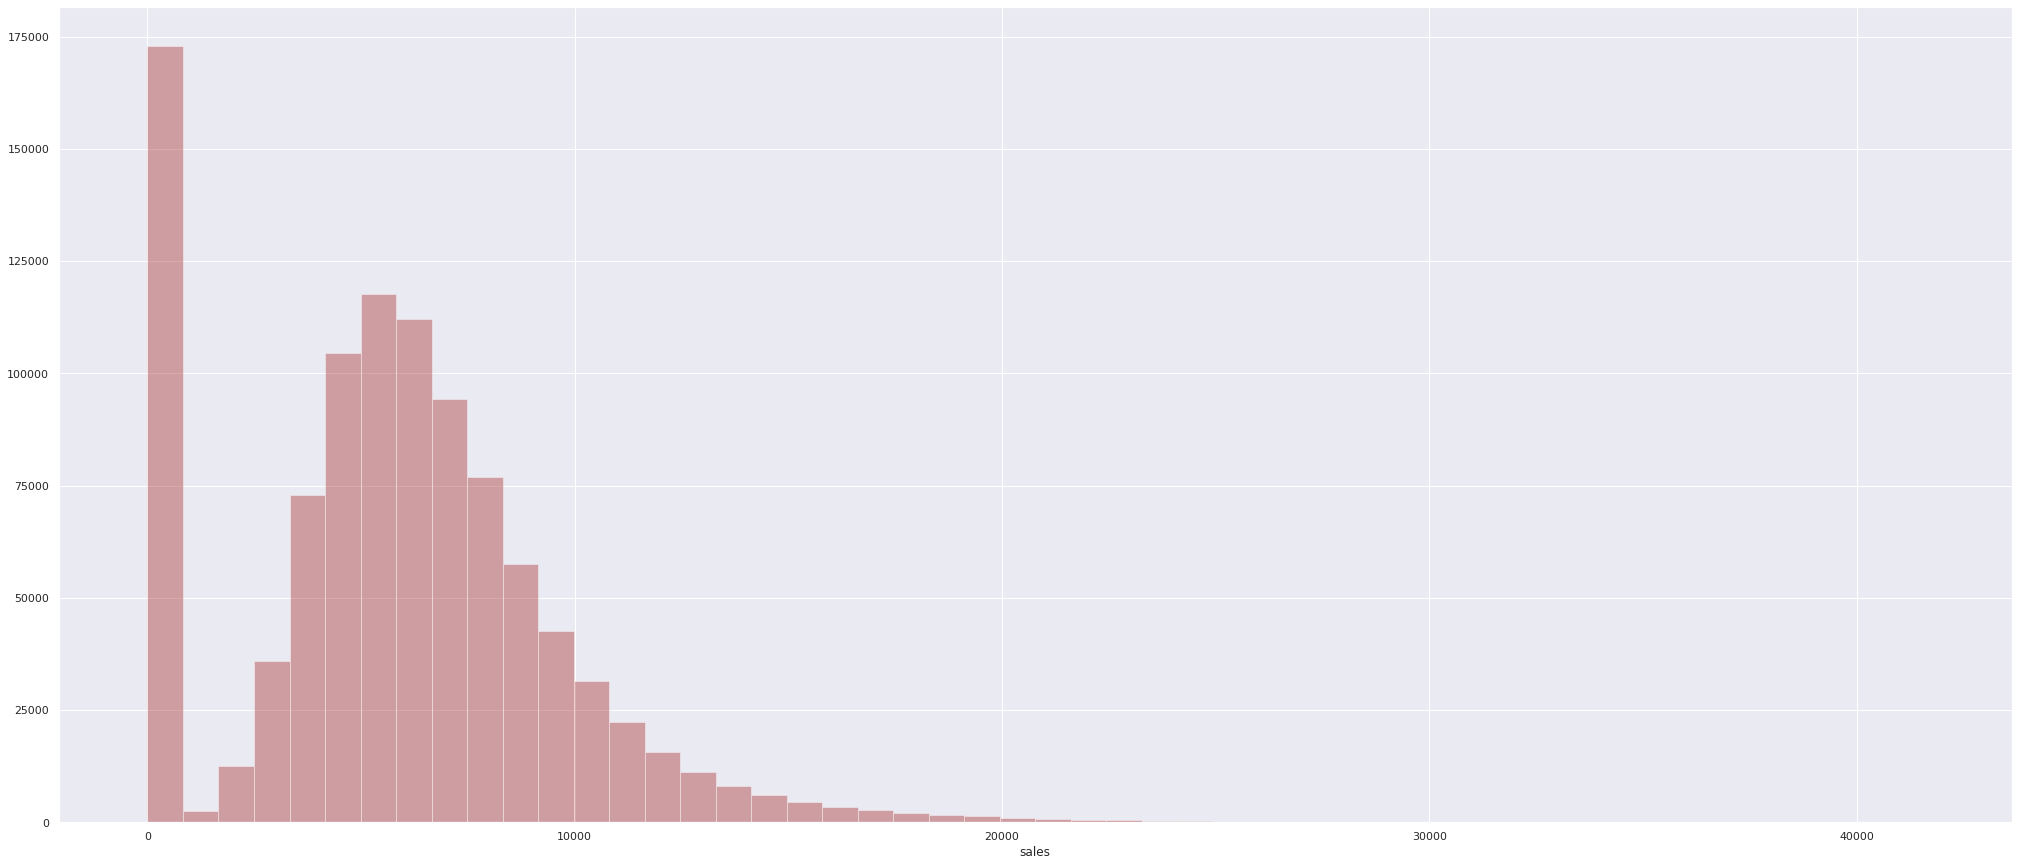

In [18]:
sns.distplot(df1['sales'], kde=False, color='brown');

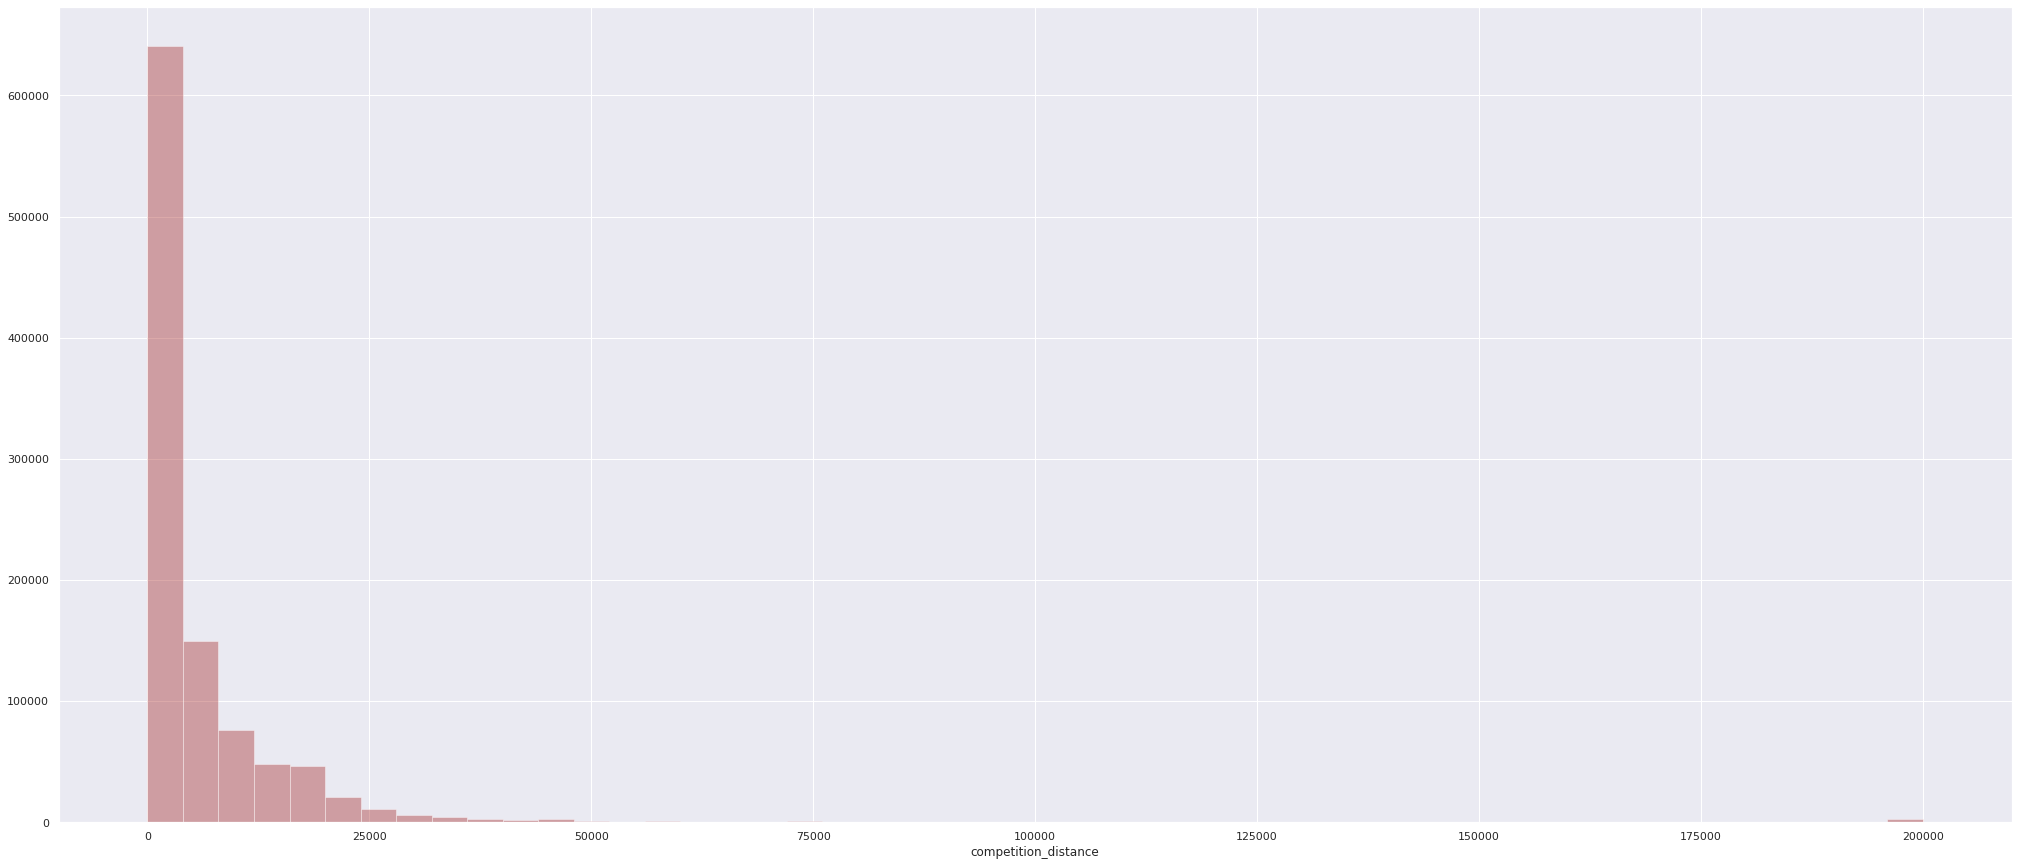

In [19]:
 sns.distplot(df1['competition_distance'], kde=False, color='brown');

### 1.7.2 Categorical Attributes

In [20]:
# Checking the unique values of each category
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

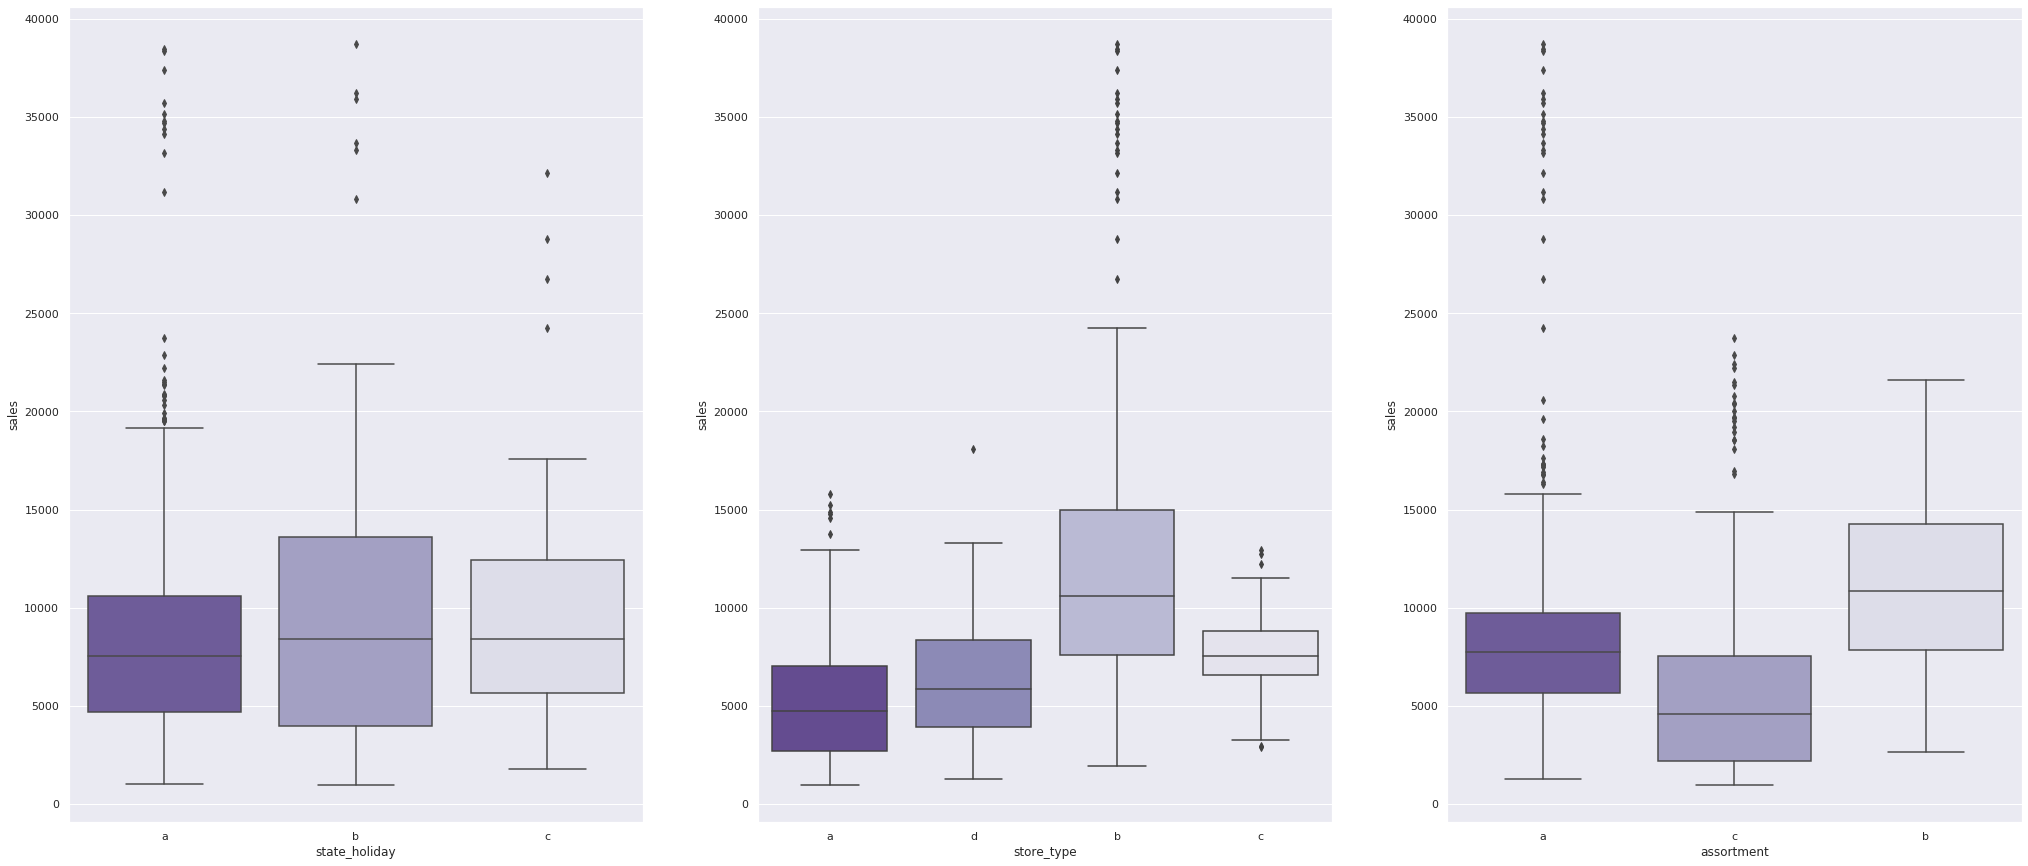

In [21]:
# Filtering the state_holiday category
aux1 = df1[( df1['state_holiday'] !='0' ) & ( df1['sales'] >0 )]

plt.subplot(1, 3, 1)
sns.boxplot( x= 'state_holiday', y='sales', data=aux1, palette="Purples_r" );

plt.subplot(1, 3, 2)
sns.boxplot( x= 'store_type', y='sales', data=aux1, palette="Purples_r" );

plt.subplot(1, 3, 3)
sns.boxplot( x= 'assortment', y='sales', data=aux1, palette="Purples_r" );

# 2.0. Step 02 -  FEATURE ENGINEERING

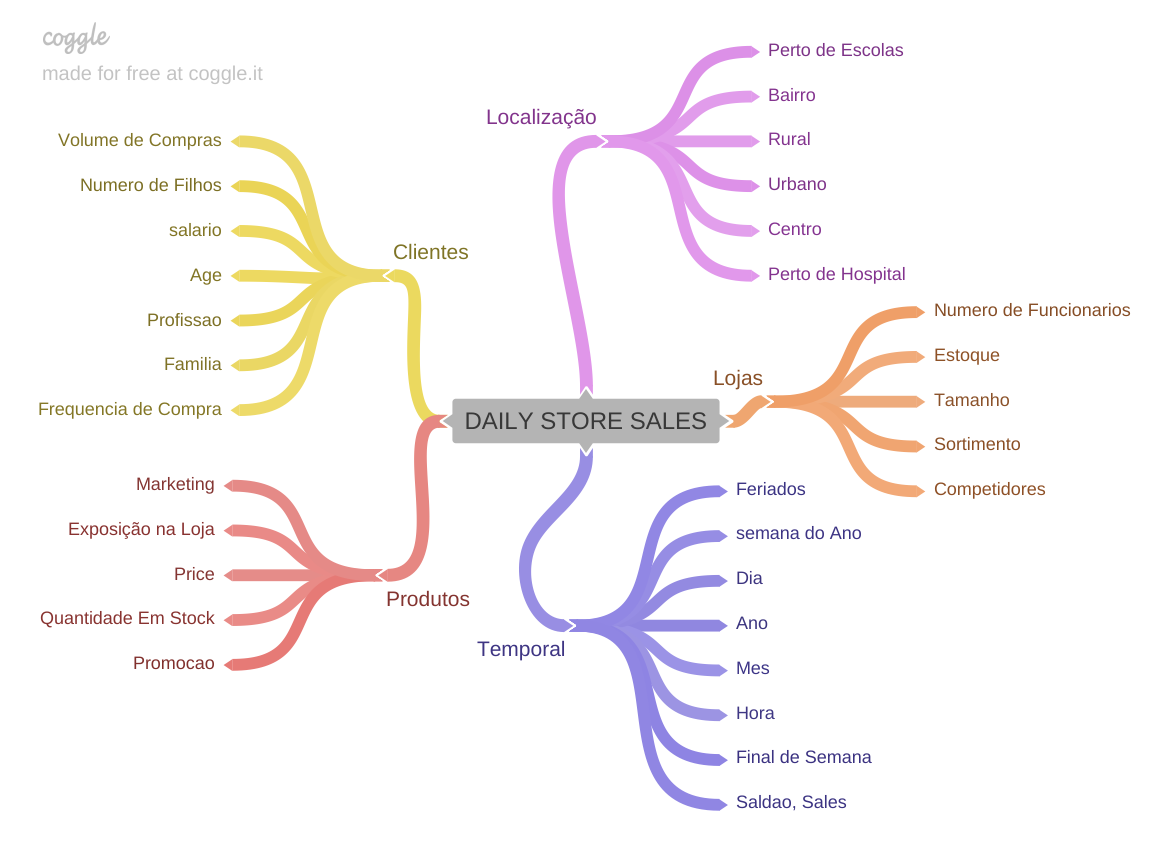

In [26]:
Image('../imgbn/MindMapHypothesis.png')

In [27]:
df2 = df1.copy()

### List of Assumptions


**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-term competitors should sell more.



**4.** Stores with promotions active for longer should sell less.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.



**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### 2.2. Feature Engineering

In [28]:
#Features created to answer the hypotheses
# year
df2['year'] = df2['date'].dt.year


# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear #New format 

#Please use Series.dt.isocalendar().week instead.  if sys.path[0] == '':


# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since 
# gathering information from ..since_of yer + ..since_of_month
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                   month=x['competition_open_since_month'],
                                                                   day=1), axis=1 )
#Number of months the competition is open
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype( int )

# promo since 
# exec join to have only one date year/week (obs.: it is necessary to convert to string)
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x:datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
#Qamount of time the promotion is active in weeks
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
# a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# a = public holiday, b = Easter holiday, c = Christmas → extraido da pgina original da competição
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Step 03 -  FILTERING VARIABLE

In [30]:
df3 = df2.copy()

### 3.1 Filtering Rows

In [31]:
#Restricting lines by values of open stores and sales greater than 0
# Assuming that:
# 'open' = 0 closed shop
# 'sales' = 0 (closed store had no sales)
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Filtering columns

In [32]:
# Excluding the 'costumers' column, as I don't have customer information in the dataset
cols_drop = ['customers', 'open',  'promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Step 04 - EDA

In [34]:
df4 = df3.copy()

### 4.1. Univariate Analysis

#### 4.1.1. Response Variable

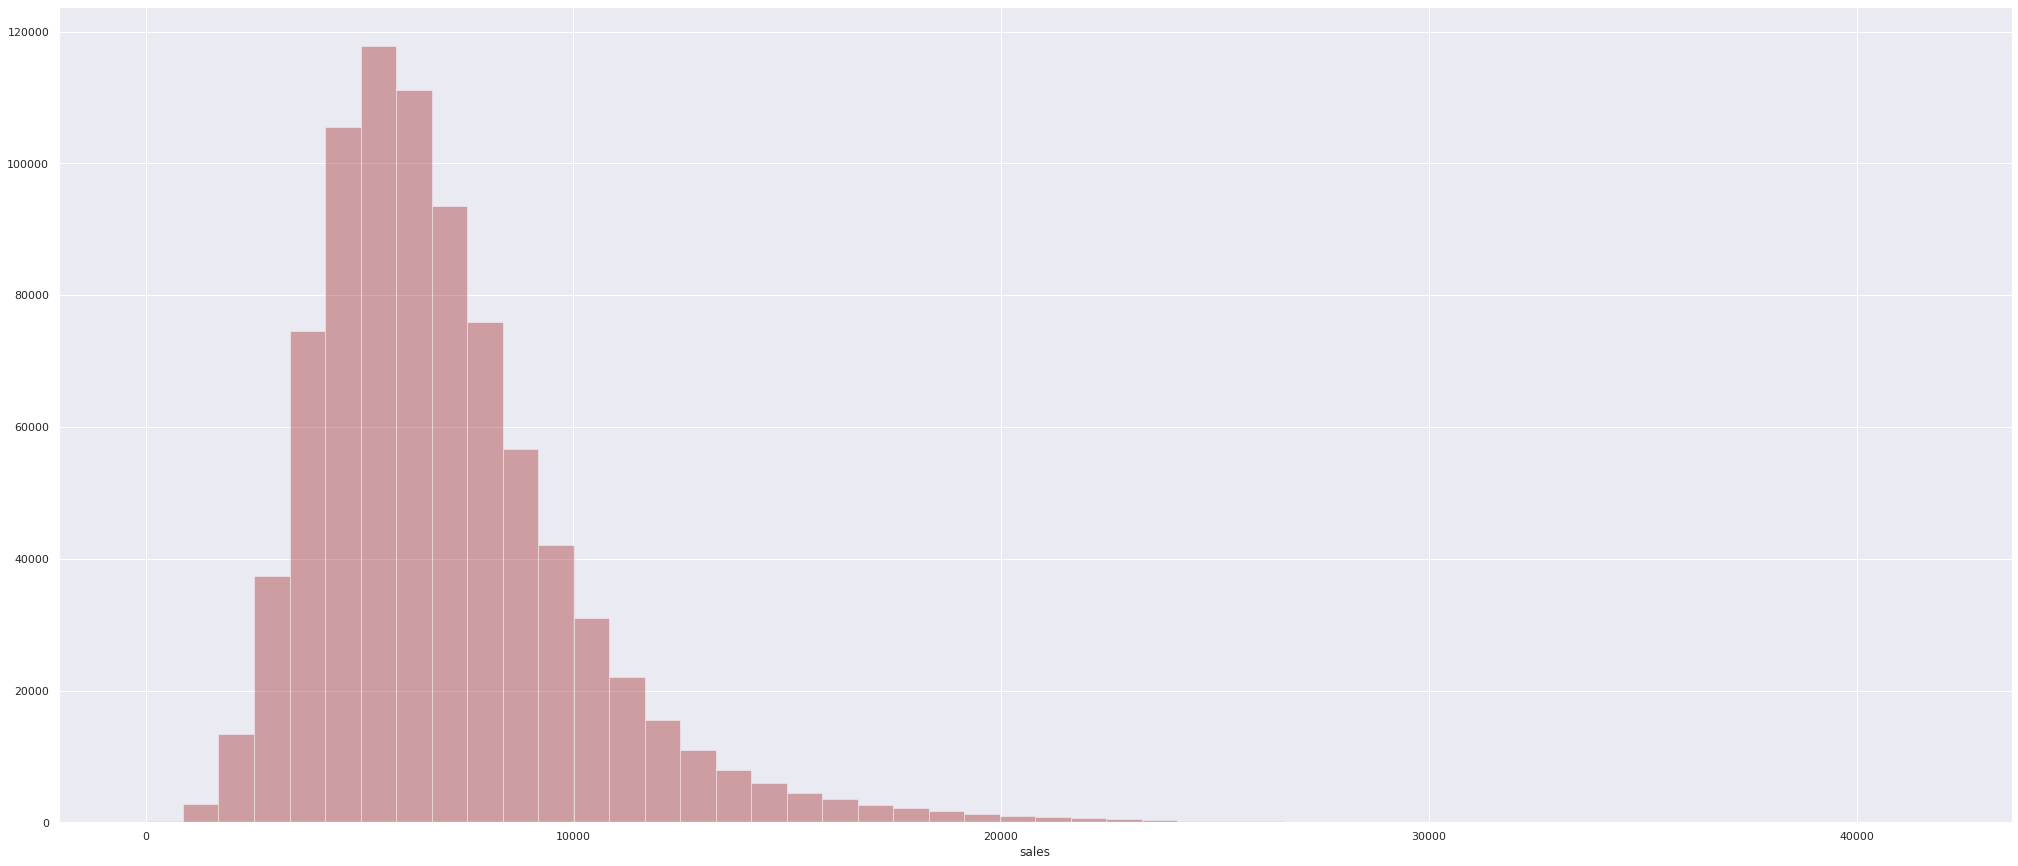

In [35]:
# Analyzing "sales" behavior
sns.distplot( df4['sales'] , kde=False, color='brown');

#### 4.1.2. Numerical Variable

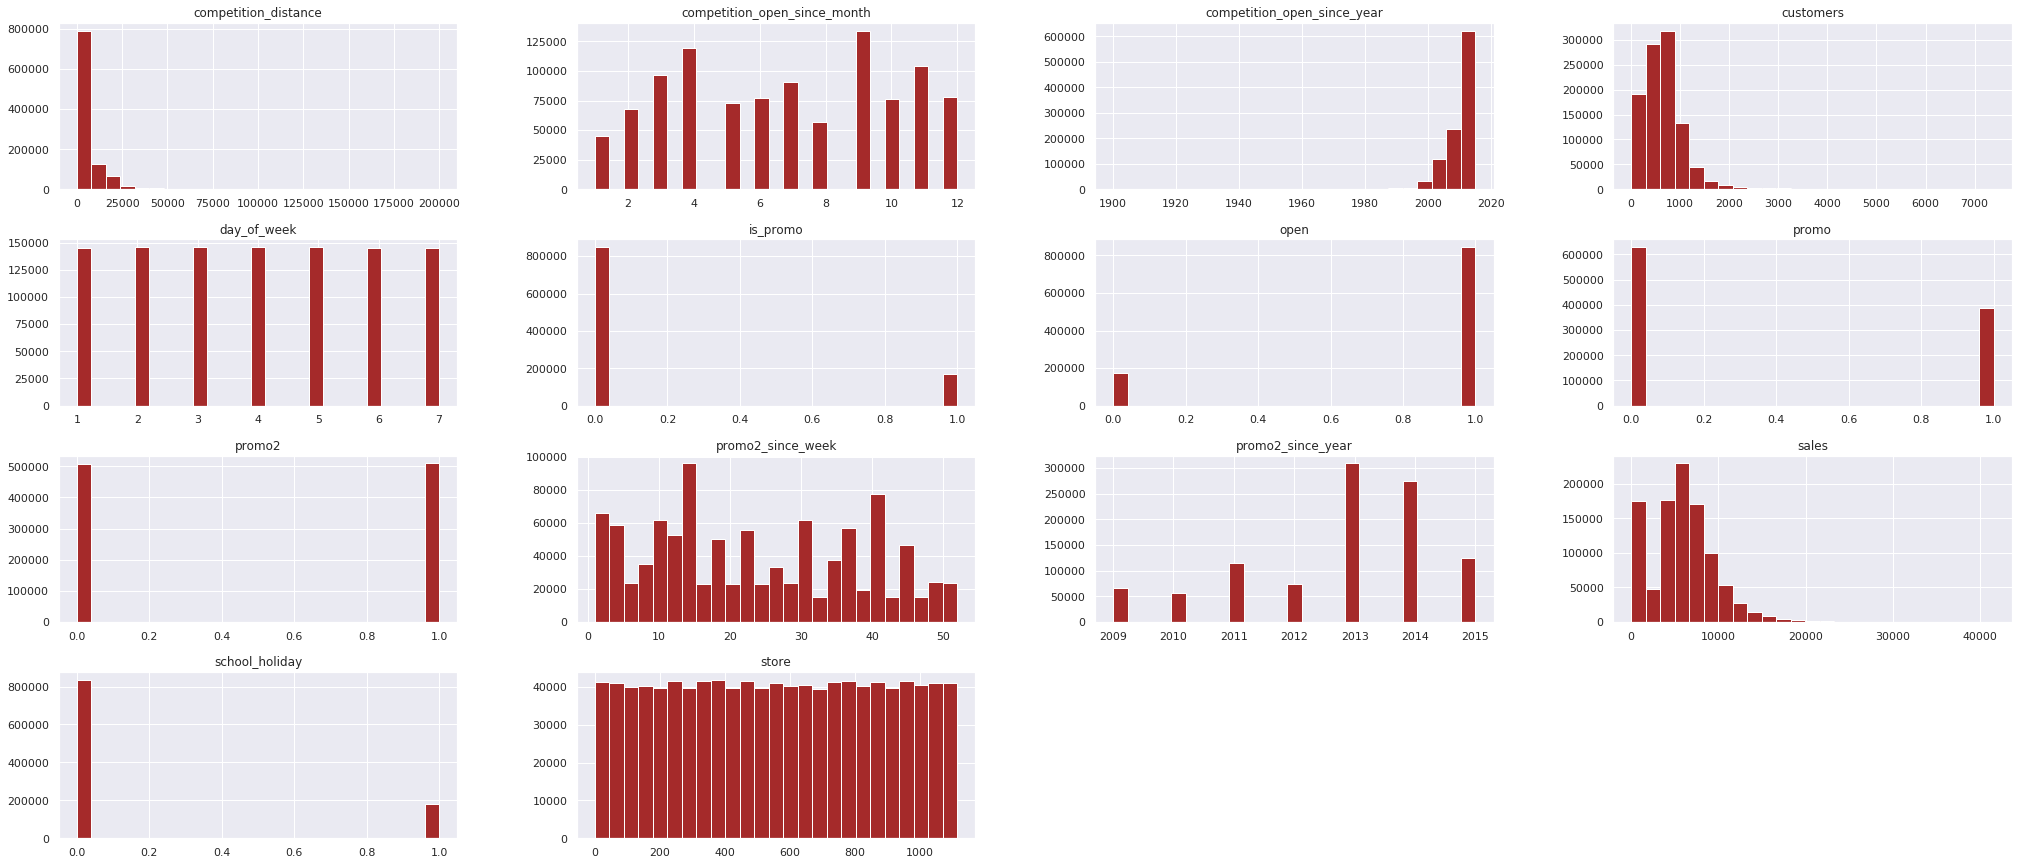

In [36]:
num_attributes.hist(bins=25, color='brown');
plt.rcParams['figure.figsize'] = [30, 15]

#### 4.1.3. Categorical Varible

In [37]:
#cat_attributes.head(); 

In [38]:
df4['state_holiday'].drop_duplicates() #Shows the types of holidays within the variable (volume idea)

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

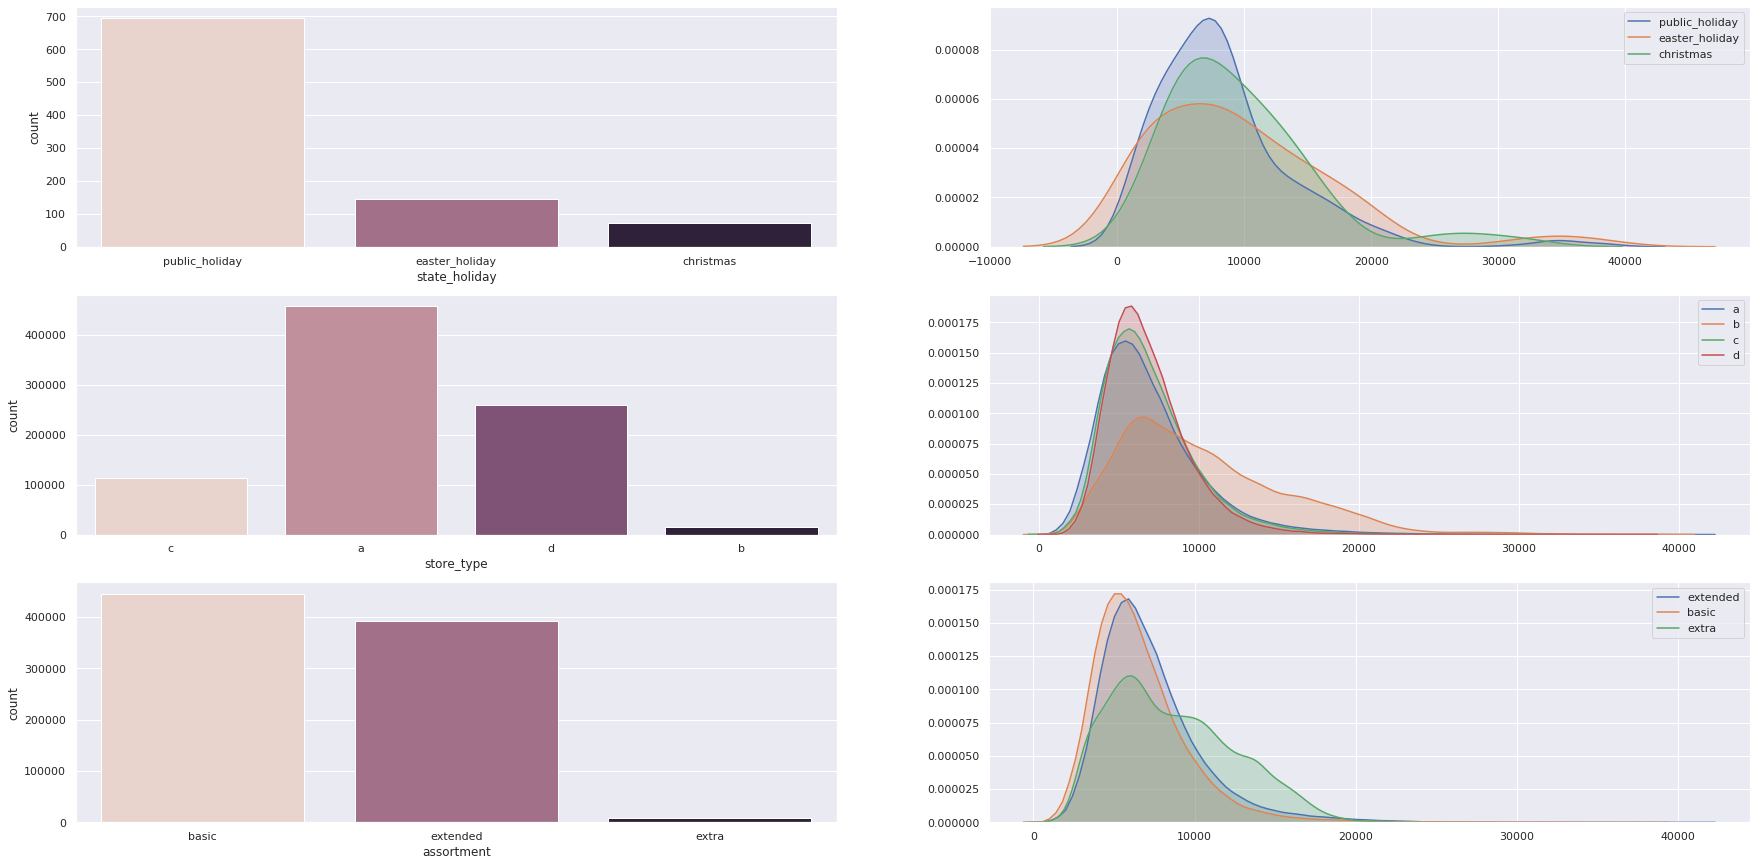

In [39]:
# state_holiday
plt.subplot(3, 2, 1);
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'], palette="ch:.05");

plt.subplot(3, 2, 2);
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',  shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',  shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',  shade=True );

# store_type
plt.subplot(3, 2, 3);
sns.countplot( df4['store_type'], palette="ch:.05");

plt.subplot(3, 2, 4);
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',  shade=True );
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',  shade=True );
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',  shade=True );
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',  shade=True );

# assortment
plt.subplot(3, 2, 5);
sns.countplot( df4['assortment'], palette="ch:.05");

plt.subplot(3, 2, 6);
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',  shade=True );
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',  shade=True );
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',  shade=True );


### 4.2. Bivariate Analysis

#### H1. Stores with a larger assortment should sell more.
Answer: <font color='red' >**False**, stores with greater assortment sell less.


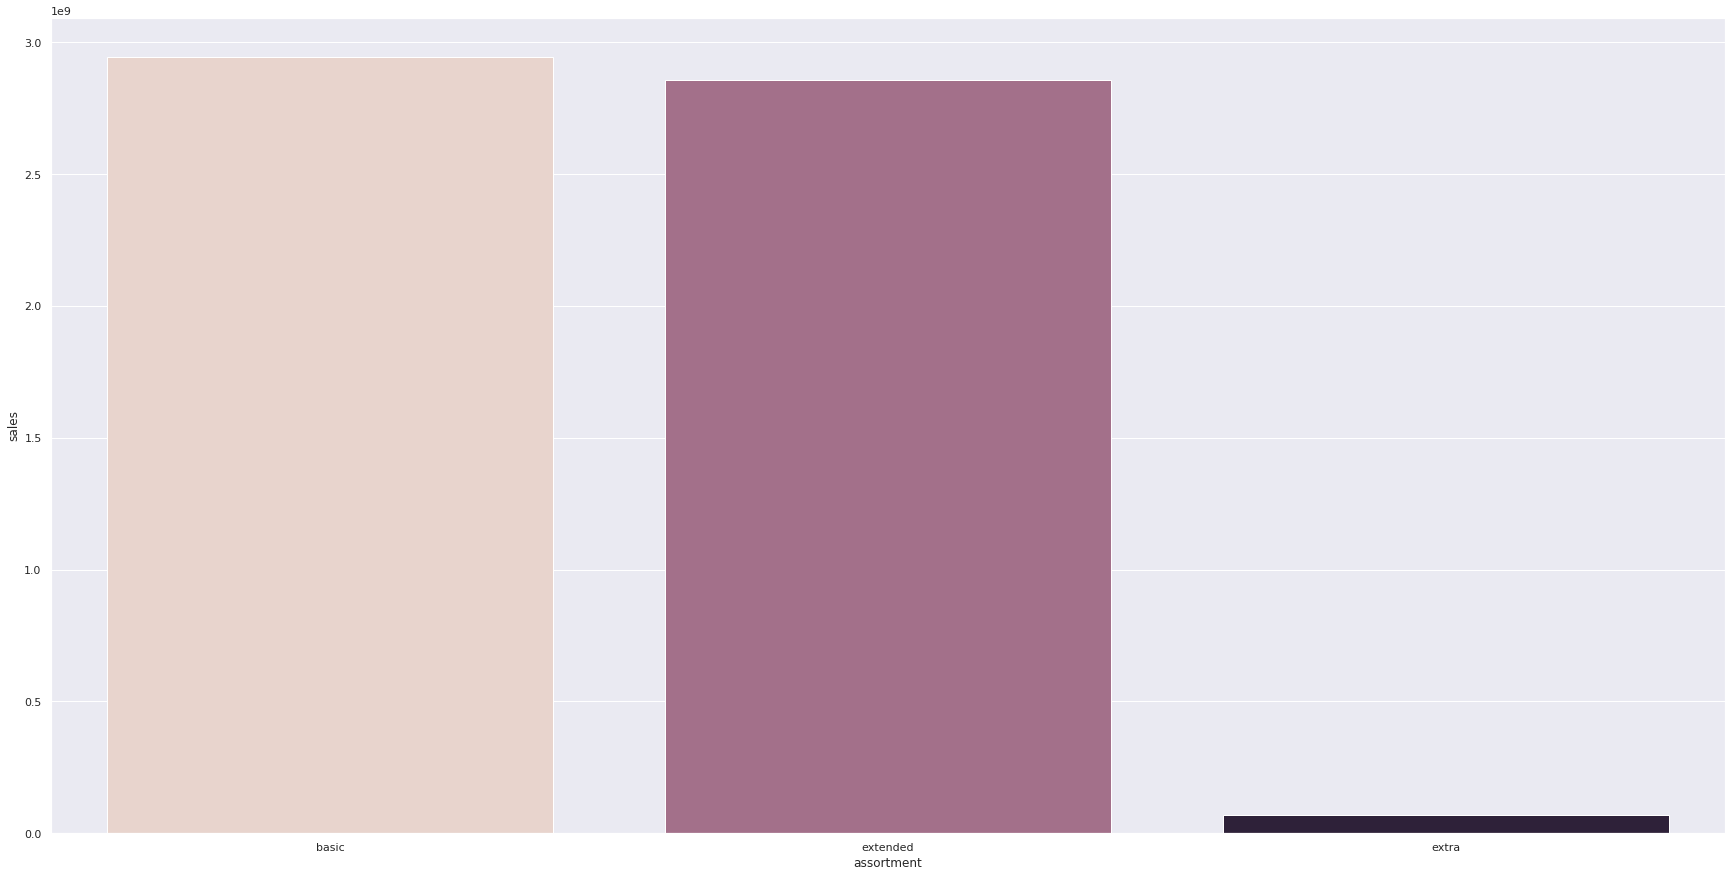

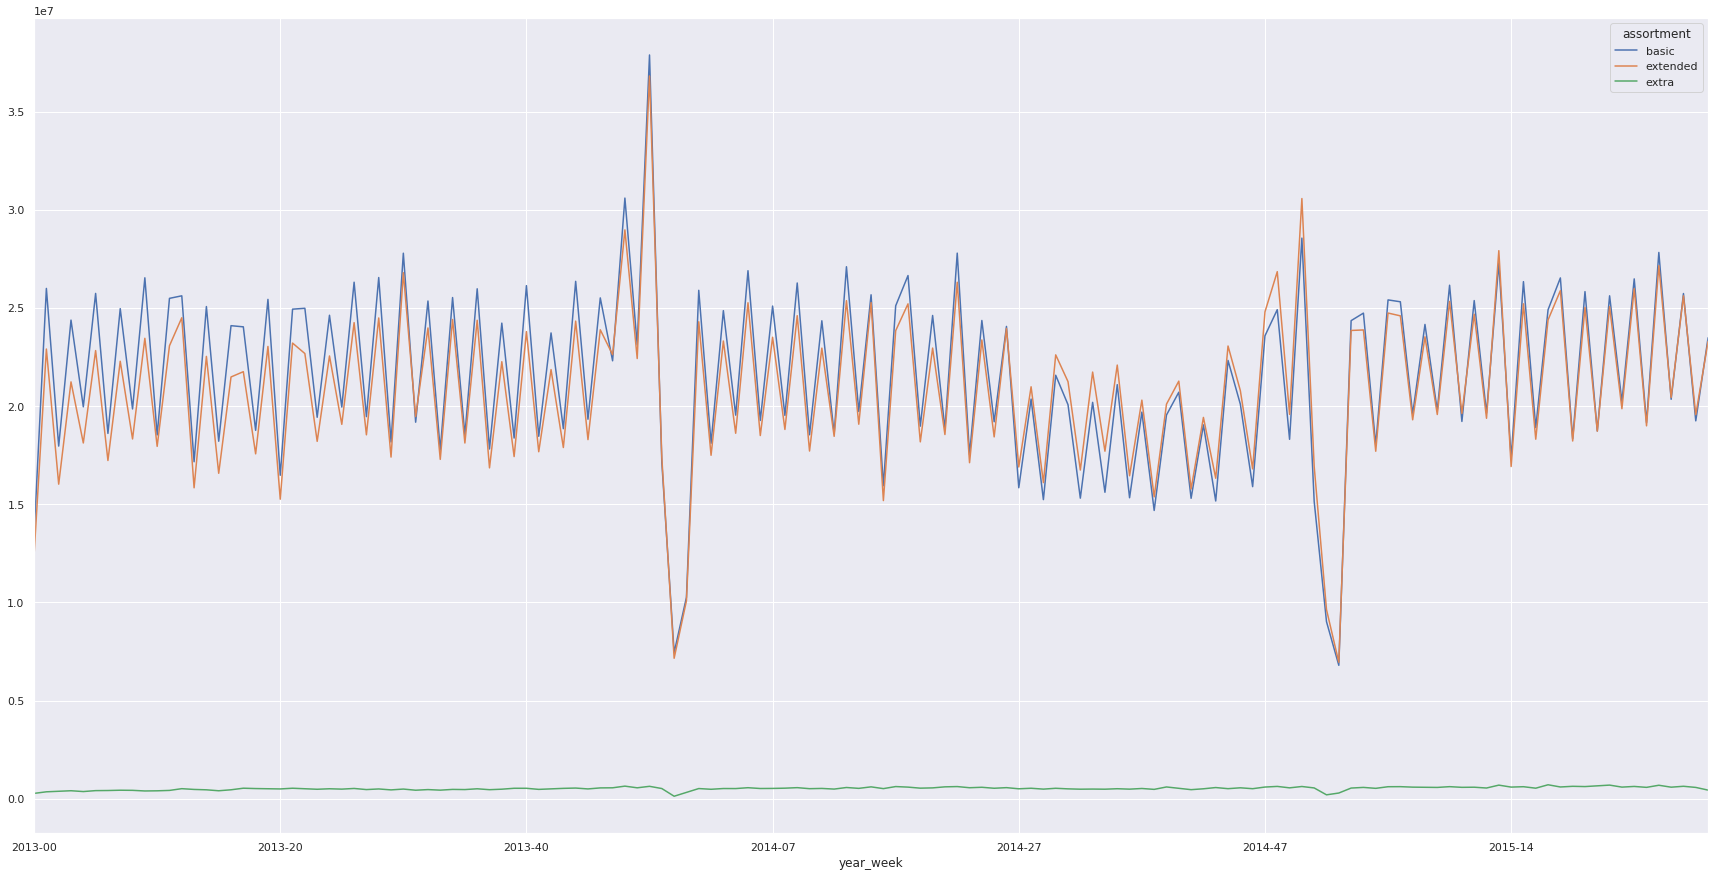

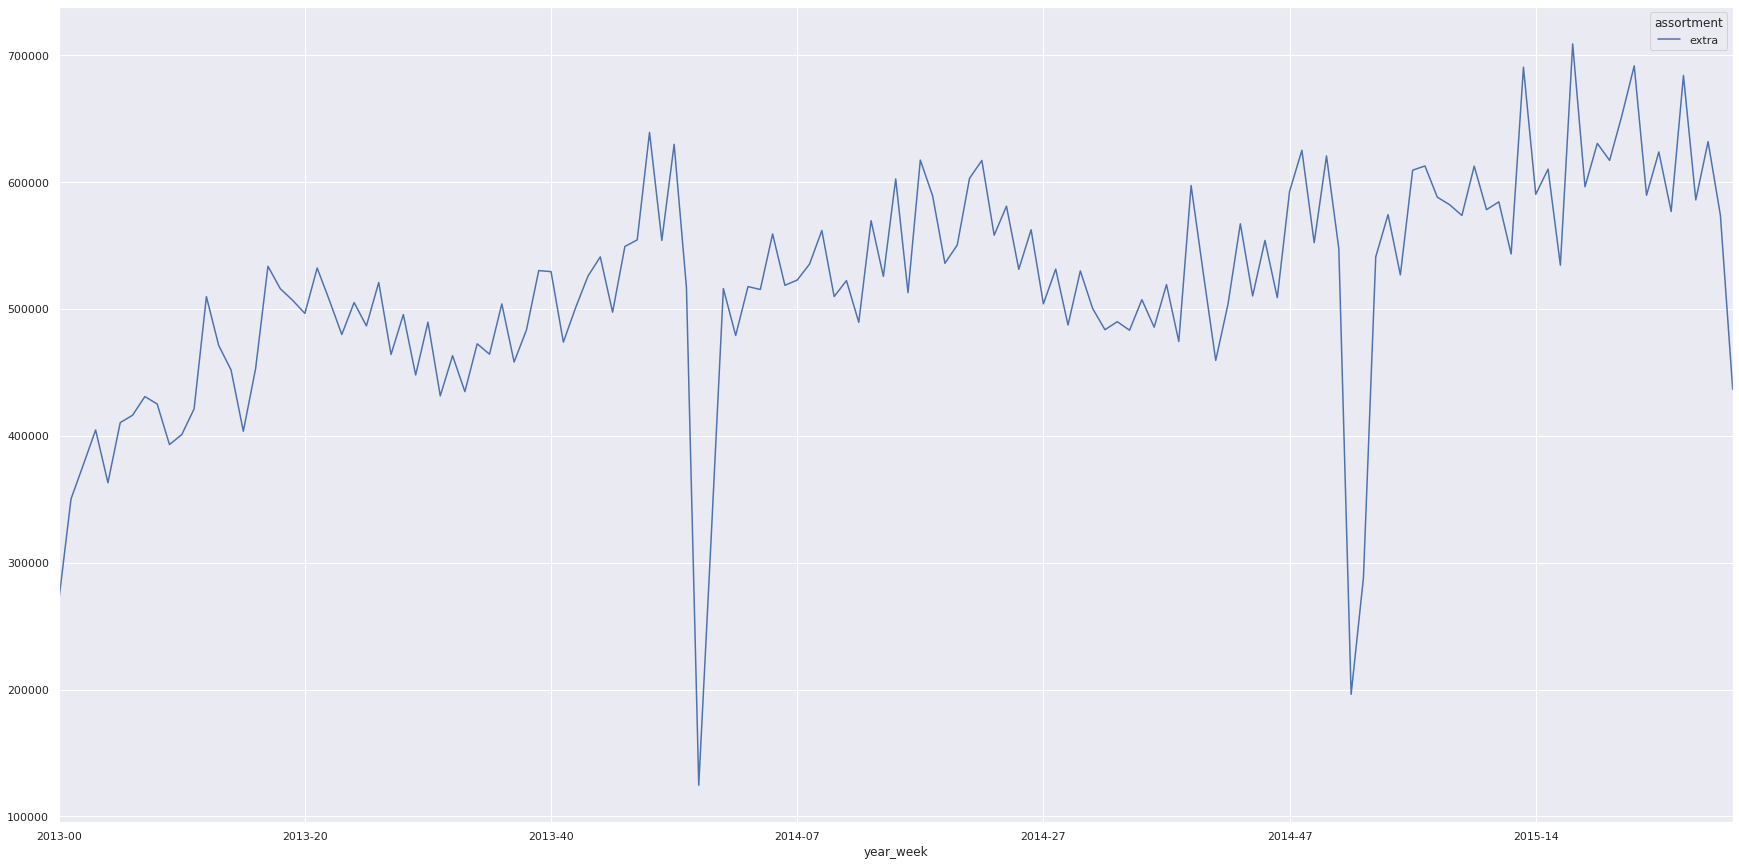

In [40]:
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, palette="ch:.05");

# O aux1 já responde essas questão. Daqui em diante vou validar se "extra", "basic" e "extend" 
#faz jús ao tamanho da loja e não apenas um breve comportamento dos clientes.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();


#### H2. Stores with closer competitors should sell less.
Answer: **False**, stores with **closer competitors, sell more!**

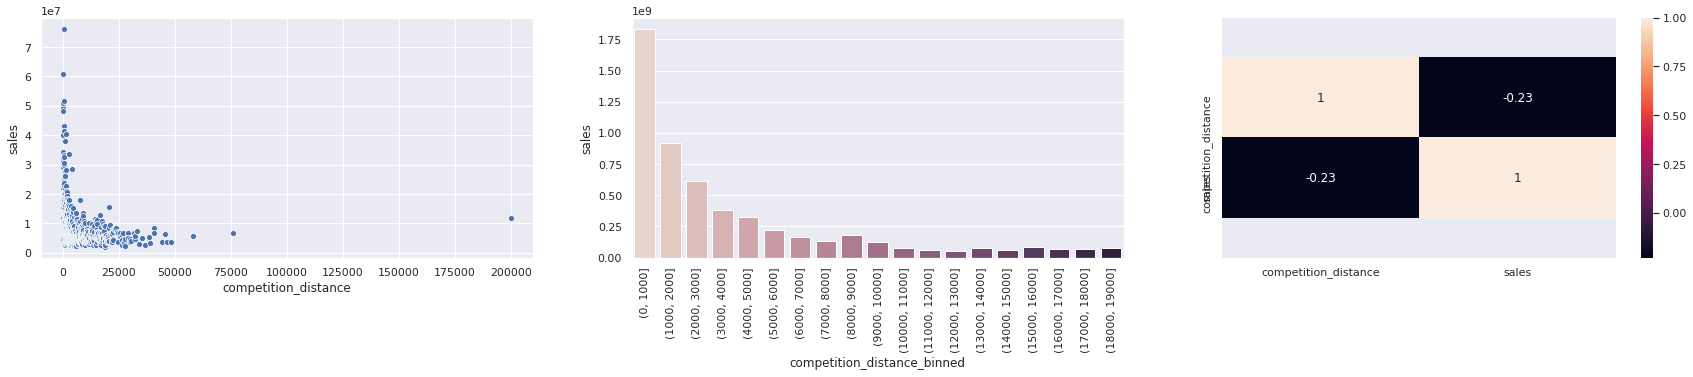

In [41]:
# Check number of sales by distance from competitors.
# Showing the total sum of sales by competitor
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index();

# Scatter Plot → USED WHEN TIMES VERY GRANULAR VALUES ON THE GRAPHICS
plt.subplot(3, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1); 

plt.subplot(3, 3, 2)                
bins = list( np.arange(0, 20000,1000));

# Method "cut" puts which bin (group) that original value belongs to
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins);

# Sum of all sales for each group (bin)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index();
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette="ch:.05");
plt.xticks(rotation=90);
         
#Mapping the correlation
plt.subplot(3, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
# shows a low correlation as the sales occurrence

# setting the values in the graph view
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

#### H3. Stores with longer-term competitors should sell more.
Answer: **False**, stores with competitors open longer, sell less!

(2.5, -0.5)

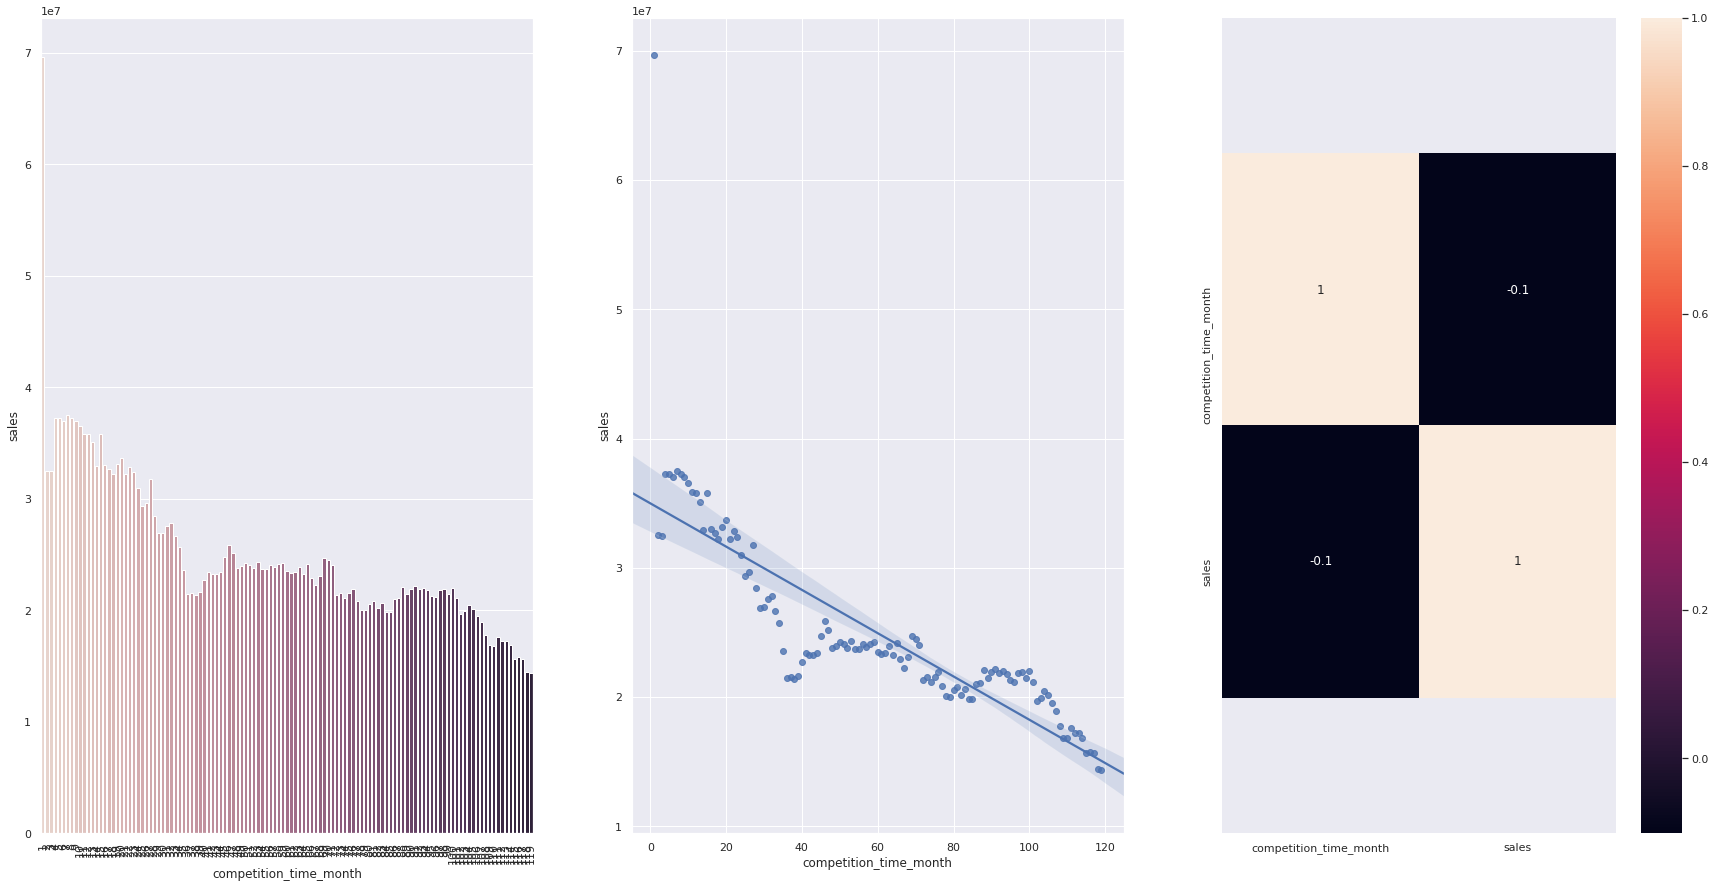

In [42]:
# Analyzing the time since the start of the competition.
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] > 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2, palette="ch:.05" )
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 )

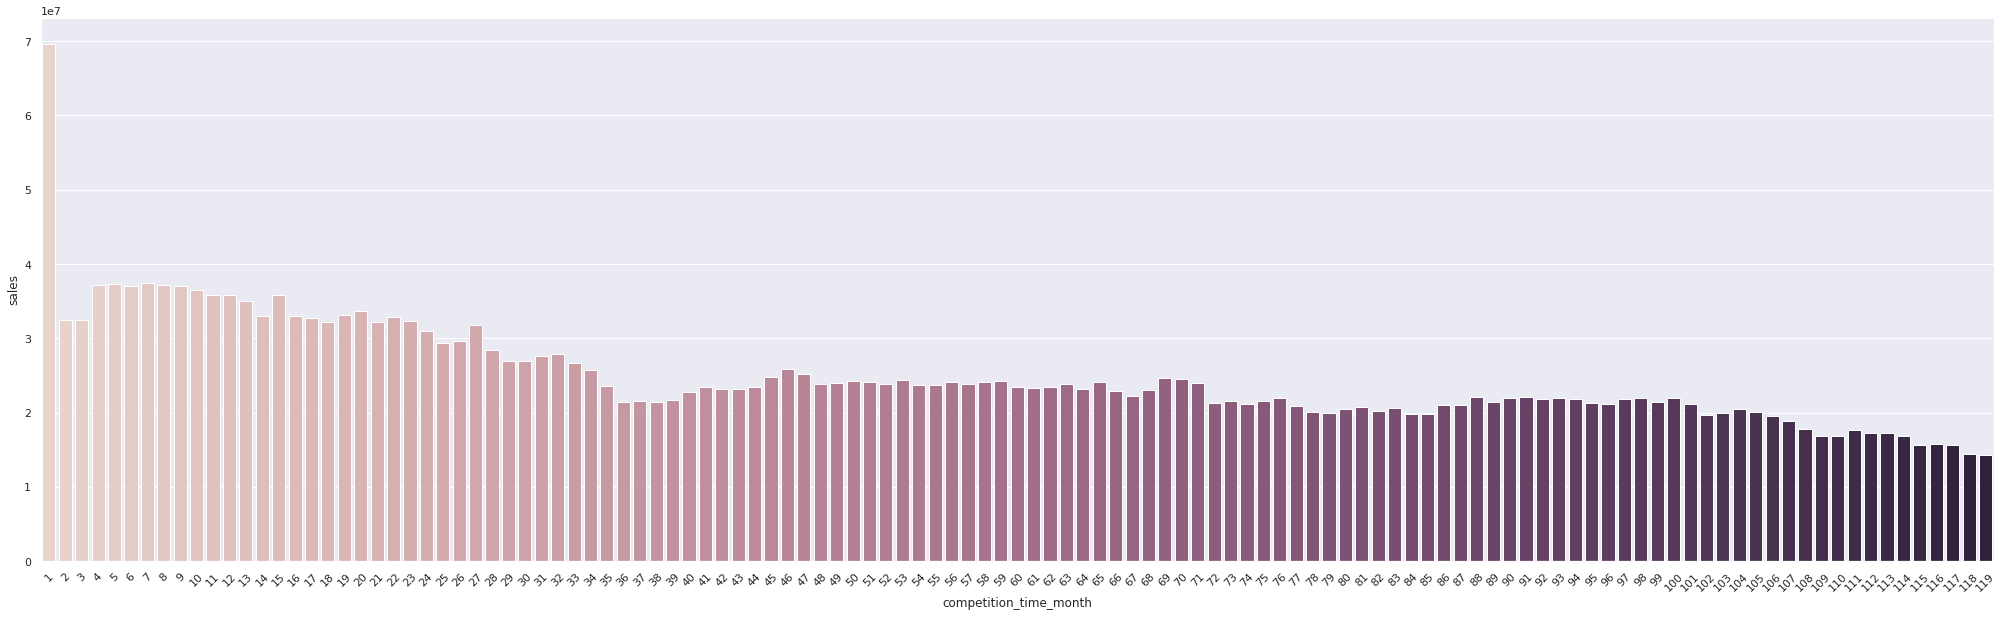

In [43]:
plt.subplots(figsize=(35, 10))
sns.barplot( x='competition_time_month', y='sales', data=aux2, palette="ch:.05" )
plt.xticks(rotation=45);


#### H4. Stores with promotions active for longer should sell less.
<source color='green'> - What do we think is happening here?
      Stores that have been in active promotions for a longer period should have a higher number of sales.

Answer: **False**. Stores with longer promo time
when selling less.

1. promo_time_week → tells us how long it has been since a promotion has been active. For this, two variables were used

     - promo2_since_week + promo2_since_year = tell us when the promotion started
     all time_week "negative" means the sale was in a traditional sales period (outside of extended promotion).
     all time_week "positive" means the sale was made within an extended promotion period.
     Note: A great opportunity to show the recruiter your ability to think about the business.

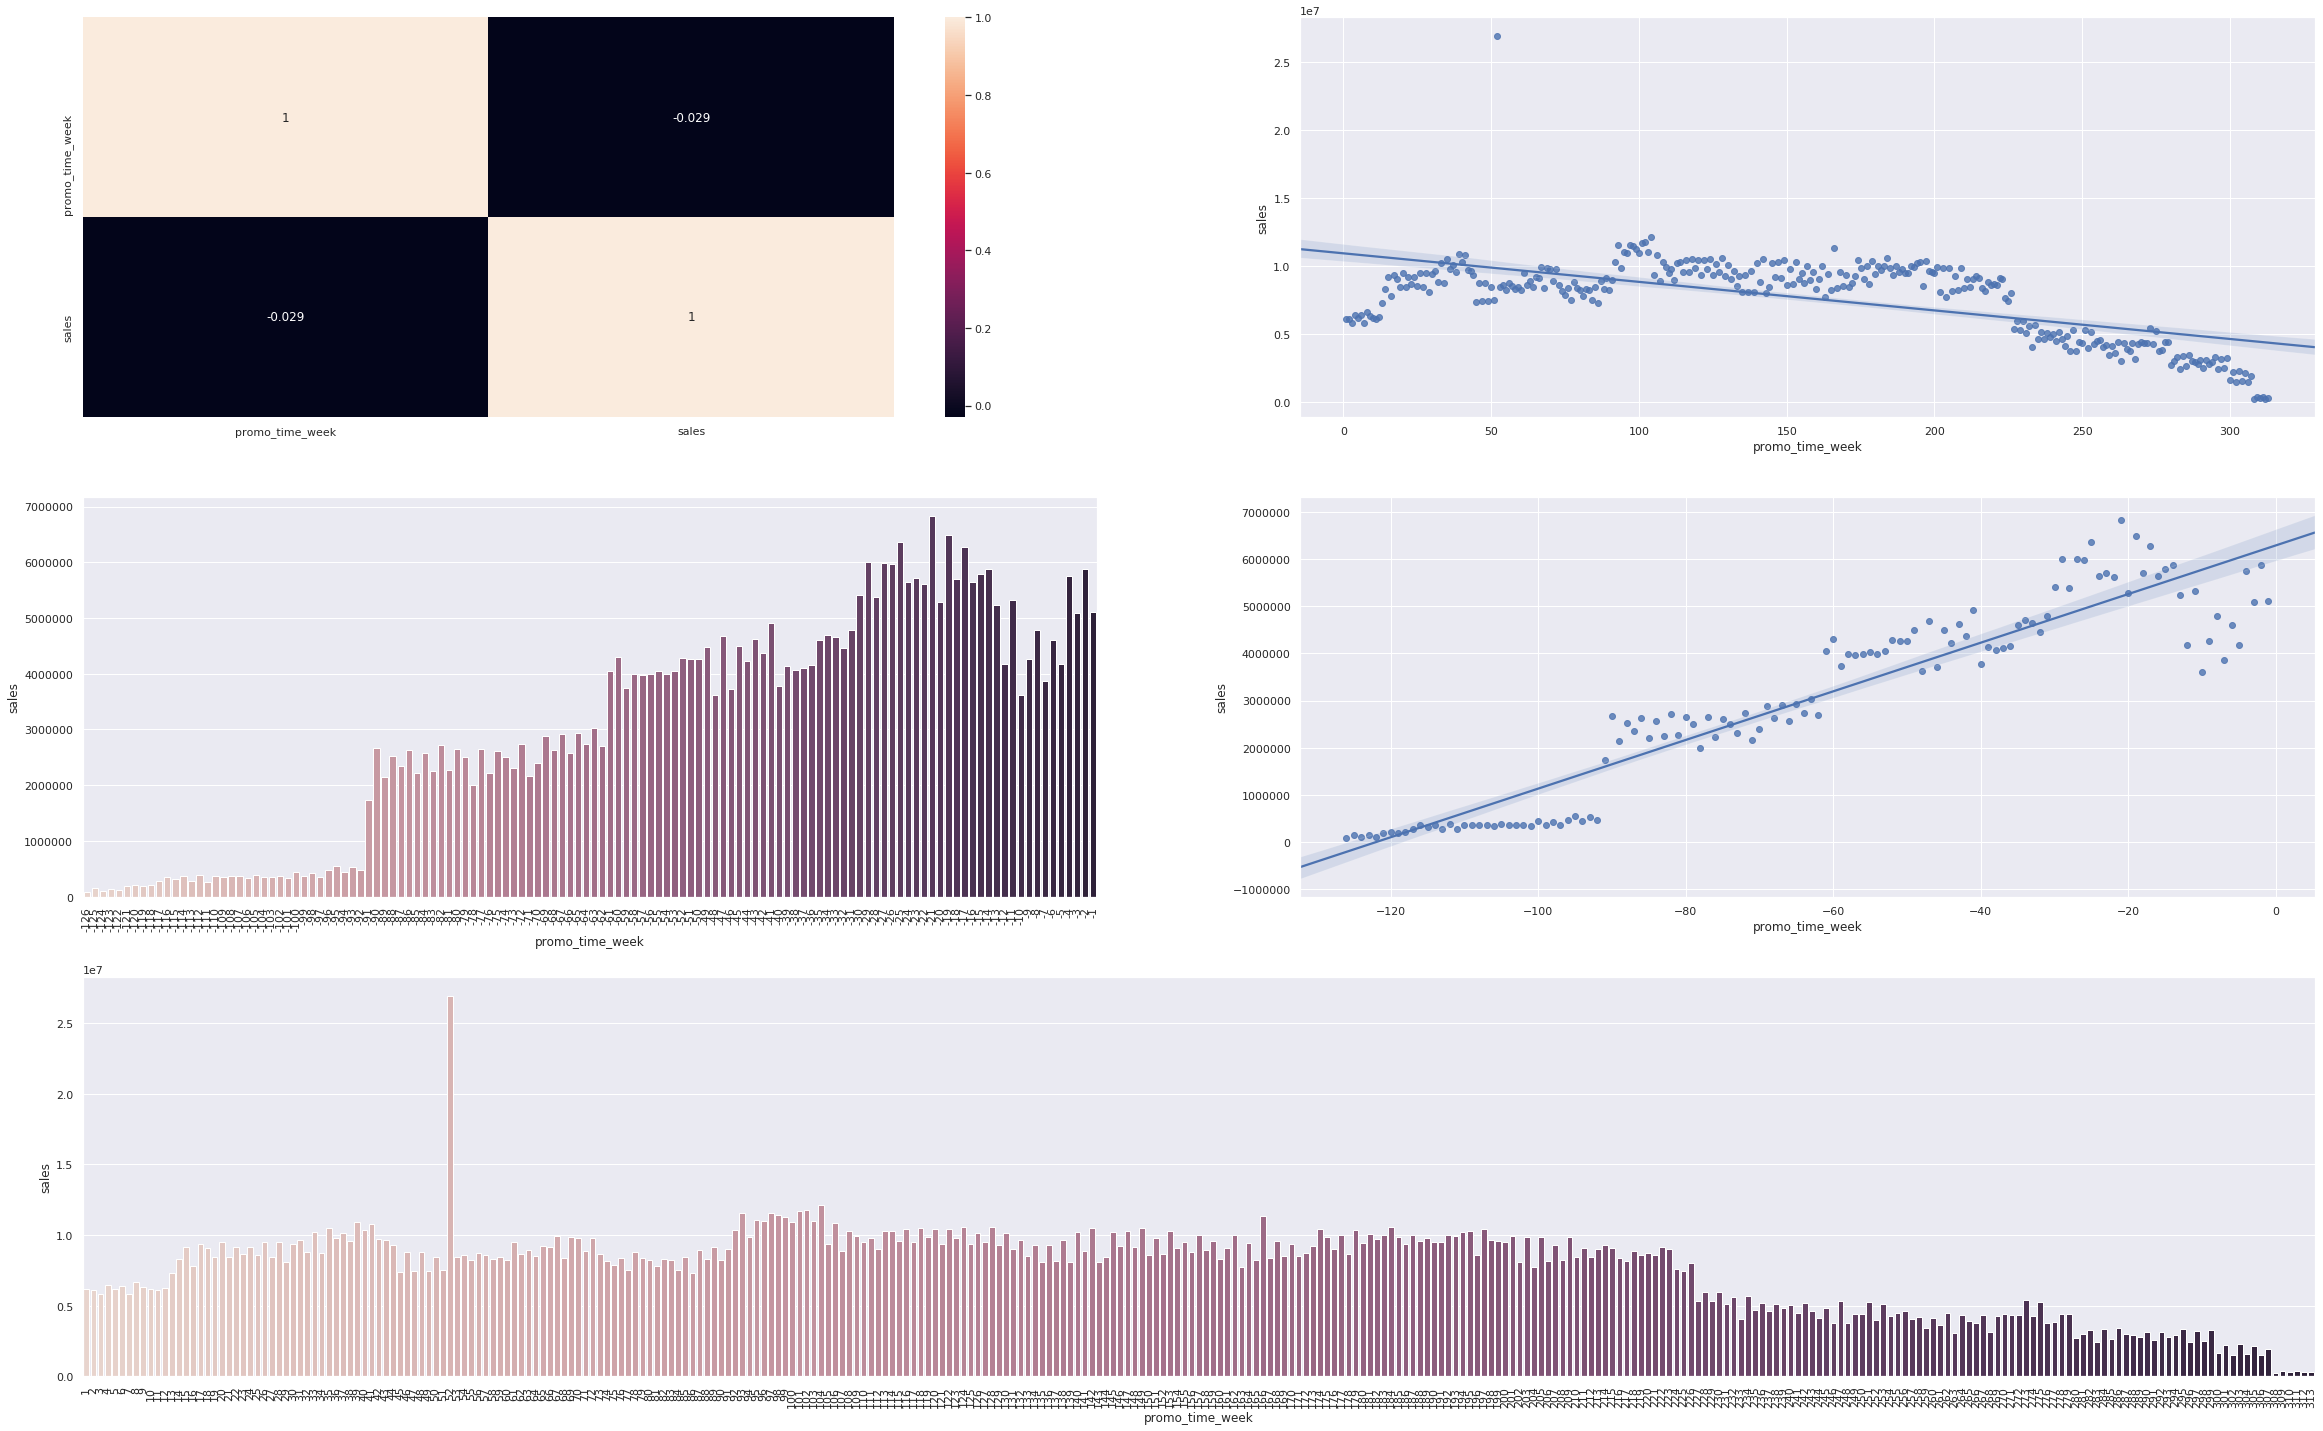

In [44]:
#import matplotlib.gridspec as gridspec
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

fig = plt.figure(figsize=(40, 25), constrained_layout=False)
spec = fig.add_gridspec(ncols=2, nrows=3)

plt.subplot(spec[2, :])
aux2 = aux1[aux1['promo_time_week'] > 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux2, palette="ch:.05");
plt.xticks( rotation=90 );

plt.subplot(spec[0, 1]) 
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot(spec[1, 0]) 
aux3 = aux1[aux1['promo_time_week'] < 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux3, palette="ch:.05" );
plt.xticks( rotation=90 );

plt.subplot(spec[1, 1]) 
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(spec[0, 0]) 
sns.heatmap( aux1.corr( method='pearson'), annot=True);


#### H6. Stores with more consecutive promotions should sell more.
Answer: **False**. Stores with more consecutive promotions sell less.


In [45]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()
# Can i show what store sell more

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


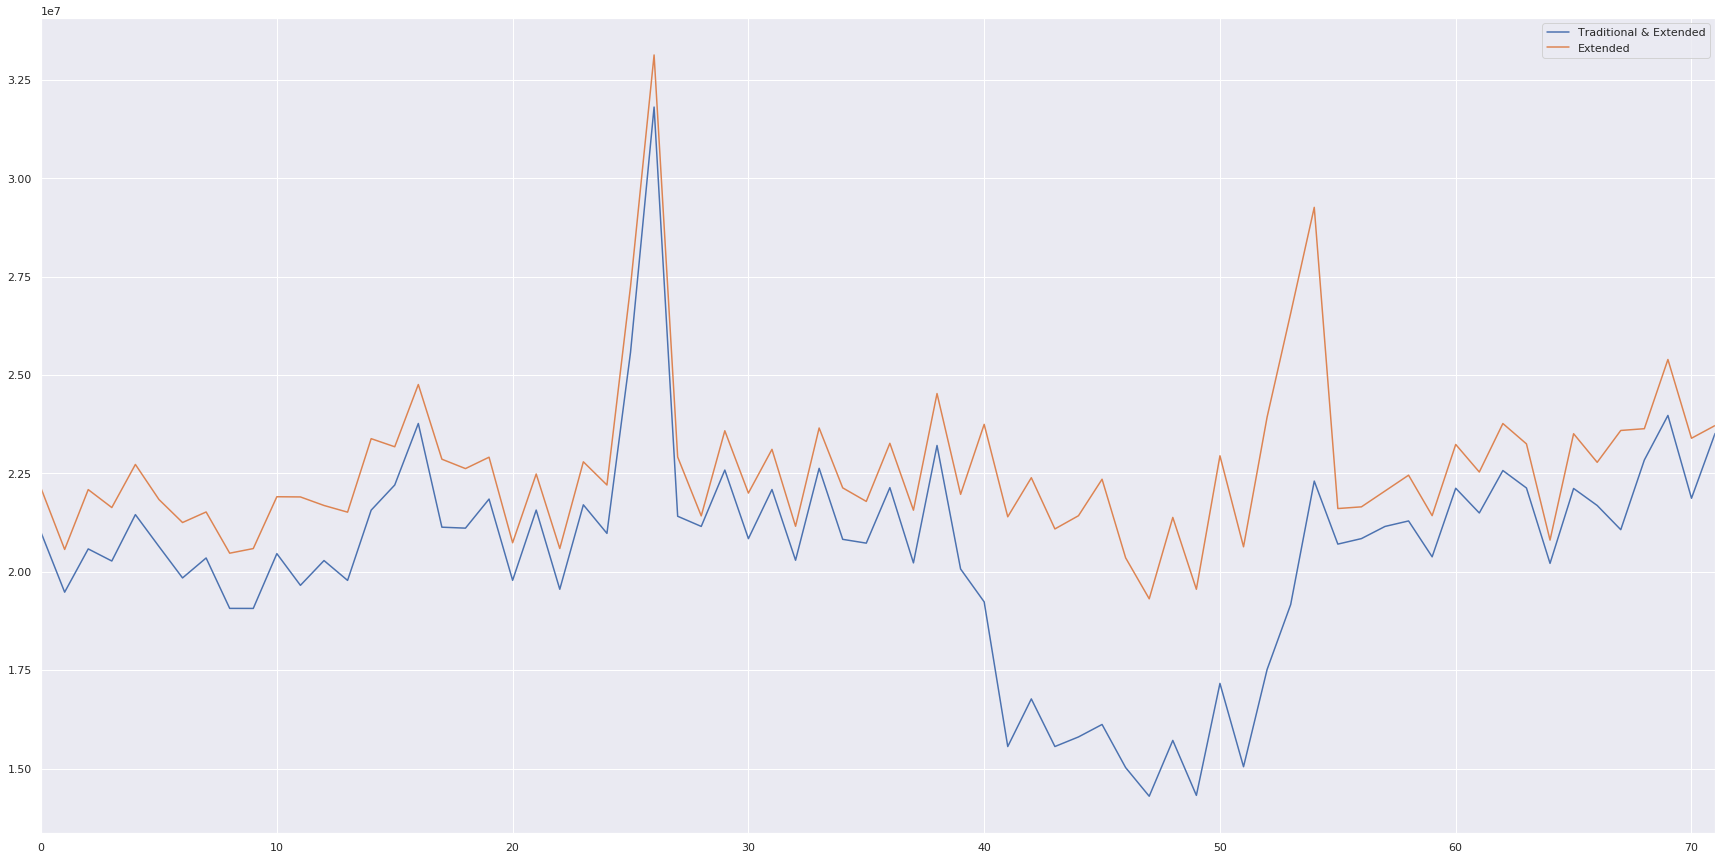

In [46]:
#Stores that only participated in the traditional promotion period
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

#Stores that participated in the traditional promotion and the extended period
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax) 

ax.legend( labels=['Traditional & Extended', 'Extended']);

#### H7. Stores open during the Christmas holiday should sell more.
Answer: **False**, stores open during Christmas break, sell less.


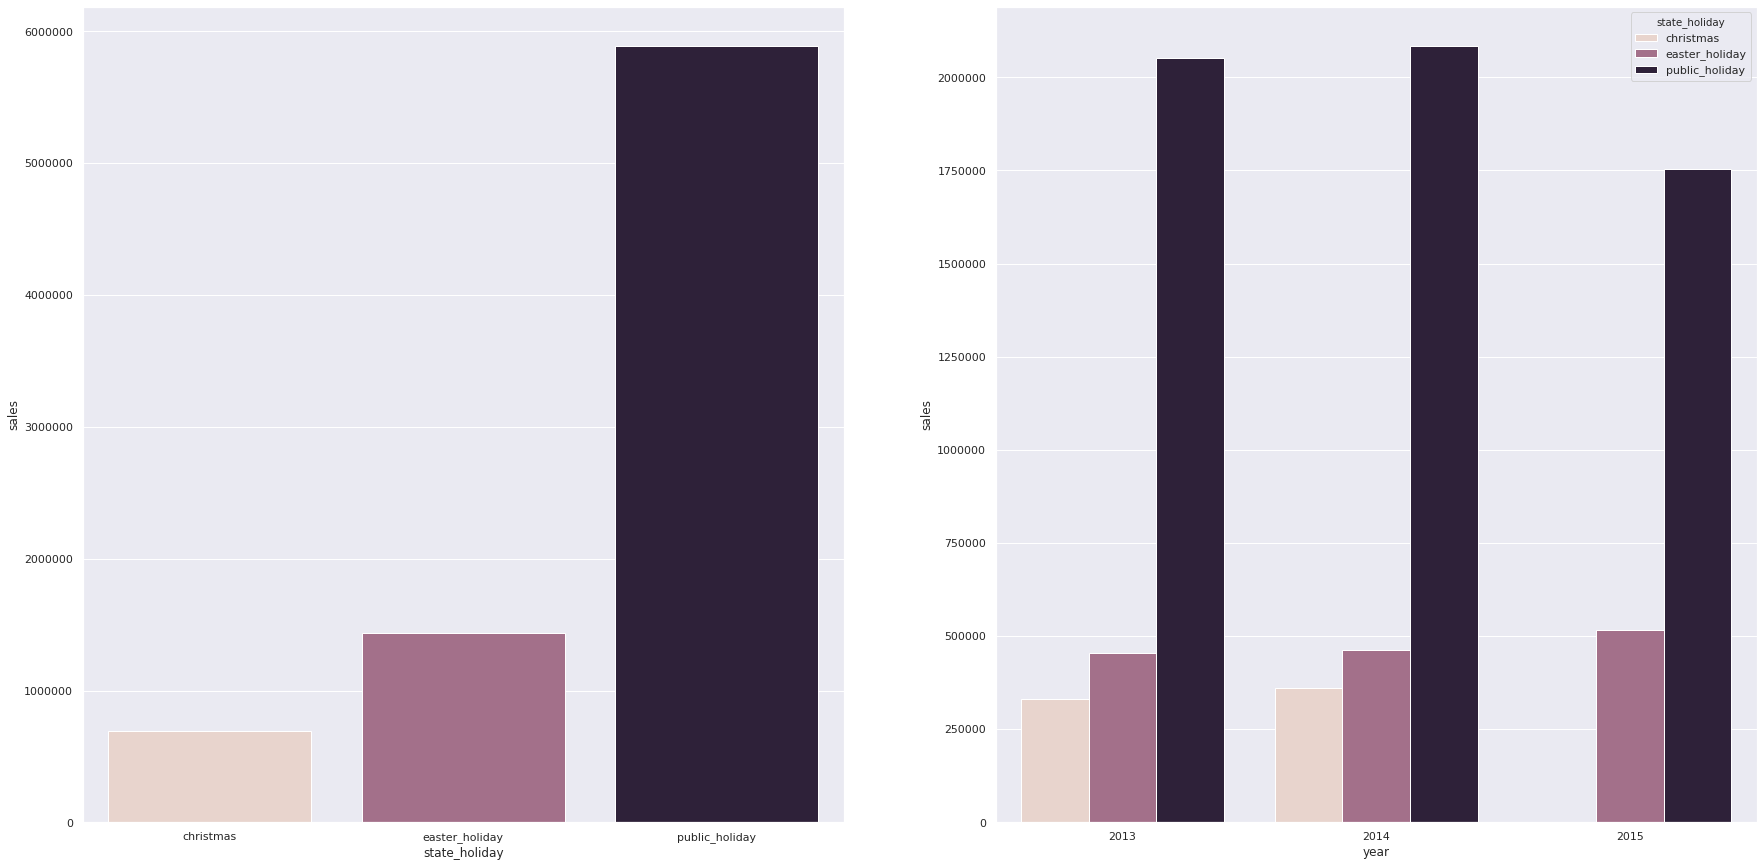

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day'] 

plt.subplot(1, 2, 1)

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1, palette="ch:.05");

plt.subplot(1, 2, 2)

aux2 = aux[['year','state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, palette="ch:.05");

#### H8. Stores should sell more over the years.

  Answer: **False**, stores sell less over the years.

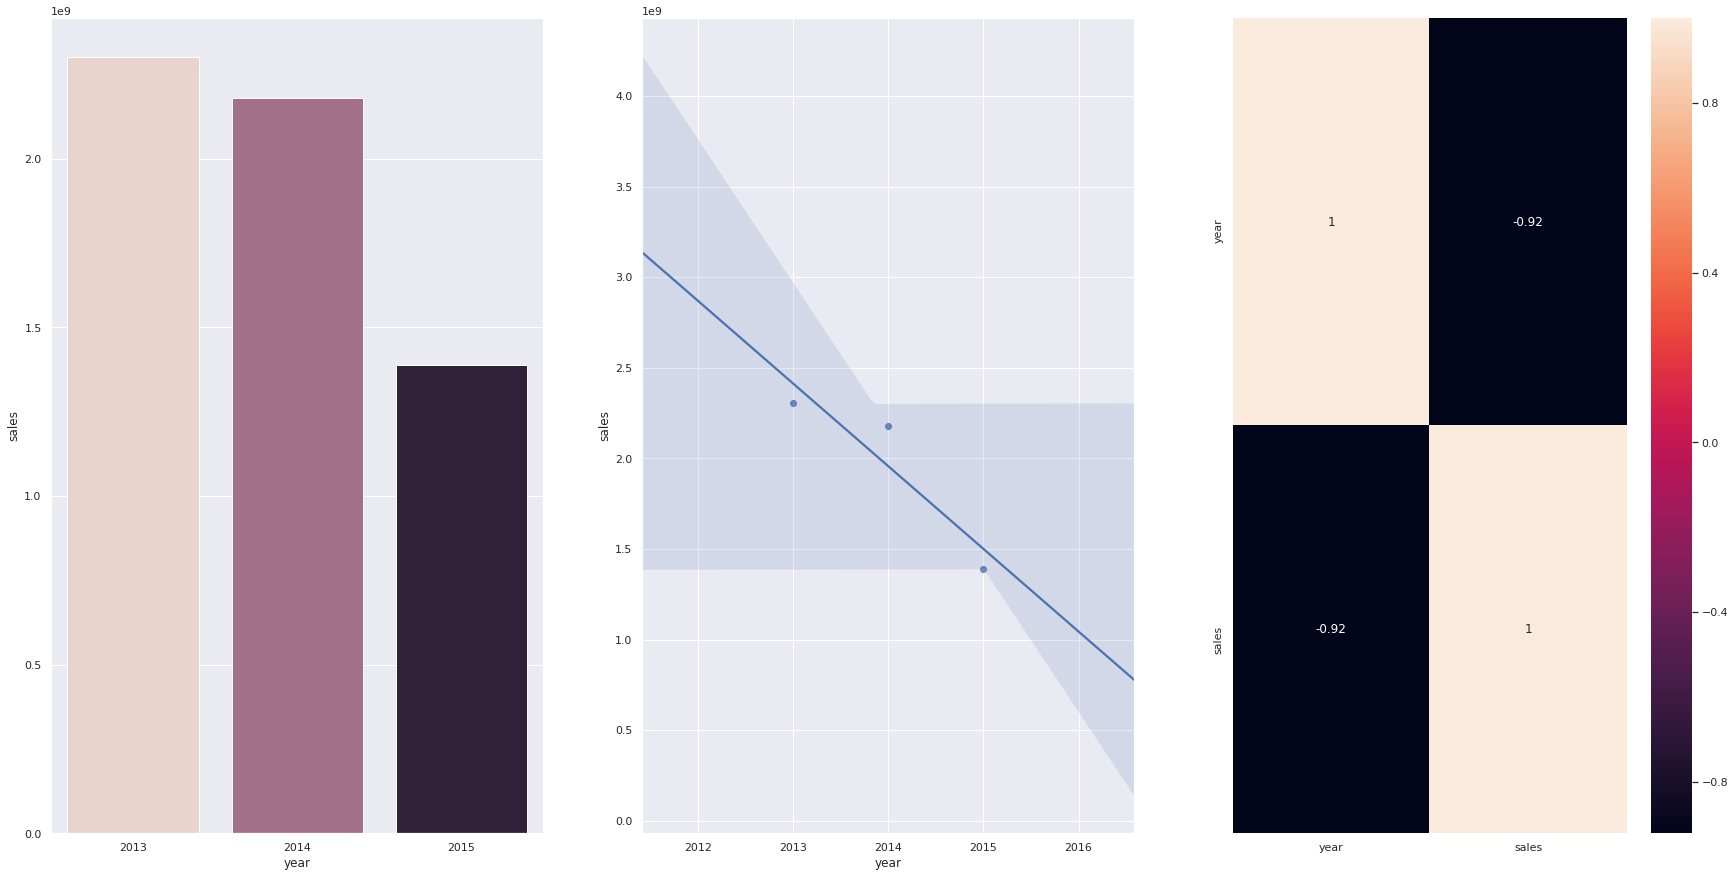

In [48]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1, palette="ch:.05");

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### H9. Stores should sell more in the second half of the year.
Answer: **False**, stores sell less from the second half.

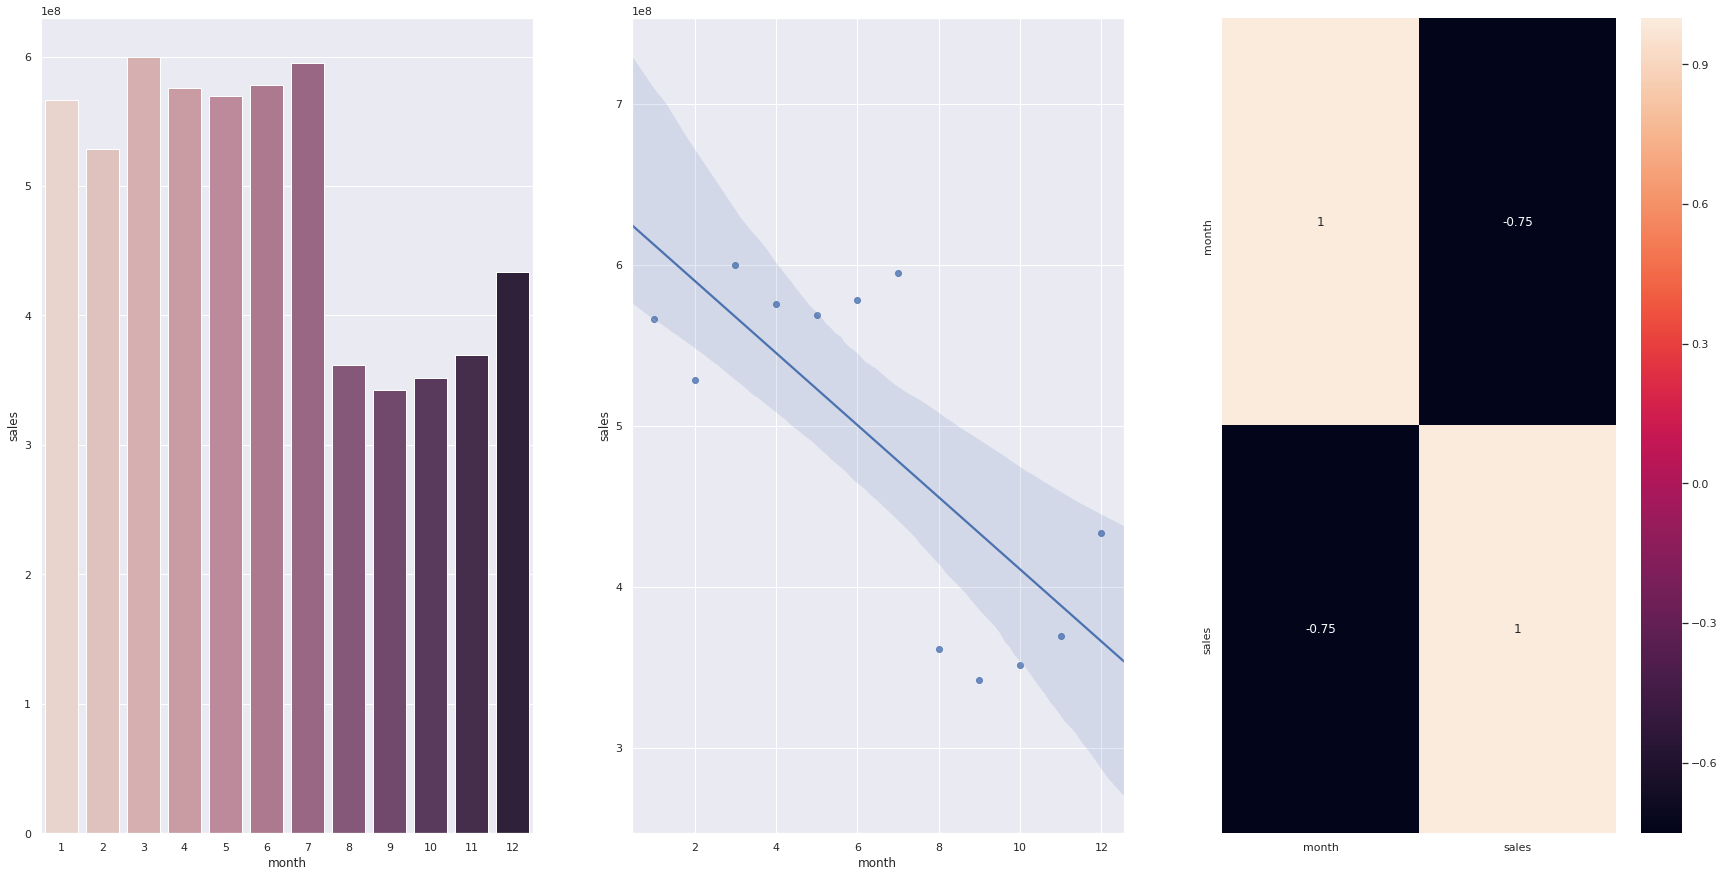

In [49]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1, palette="ch:.05");

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### H10. Stores should sell more after the 10th of each month.
Answer: **True**, stores sell more after the 10th of each month.

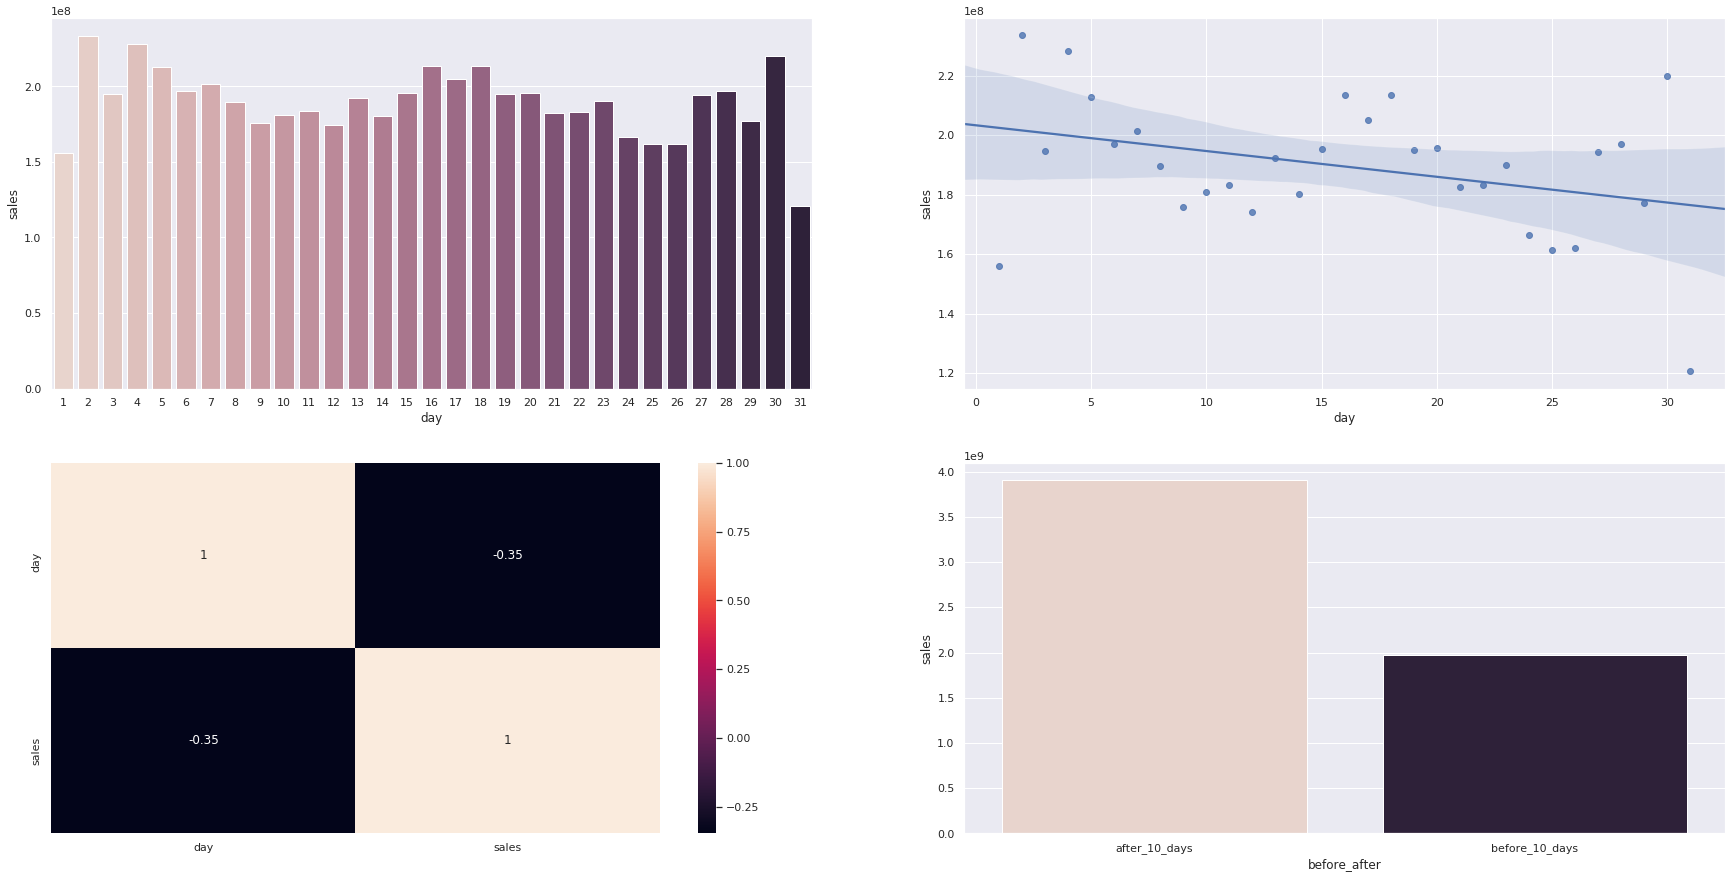

In [50]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1, palette="ch:.05");

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2, 2, 4)
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index();
sns.barplot(x='before_after', y='sales', data=aux2, palette="ch:.05" );

#### H11. Stores should sell less on weekends.
Answer: **True**, stores sell less on weekends.    

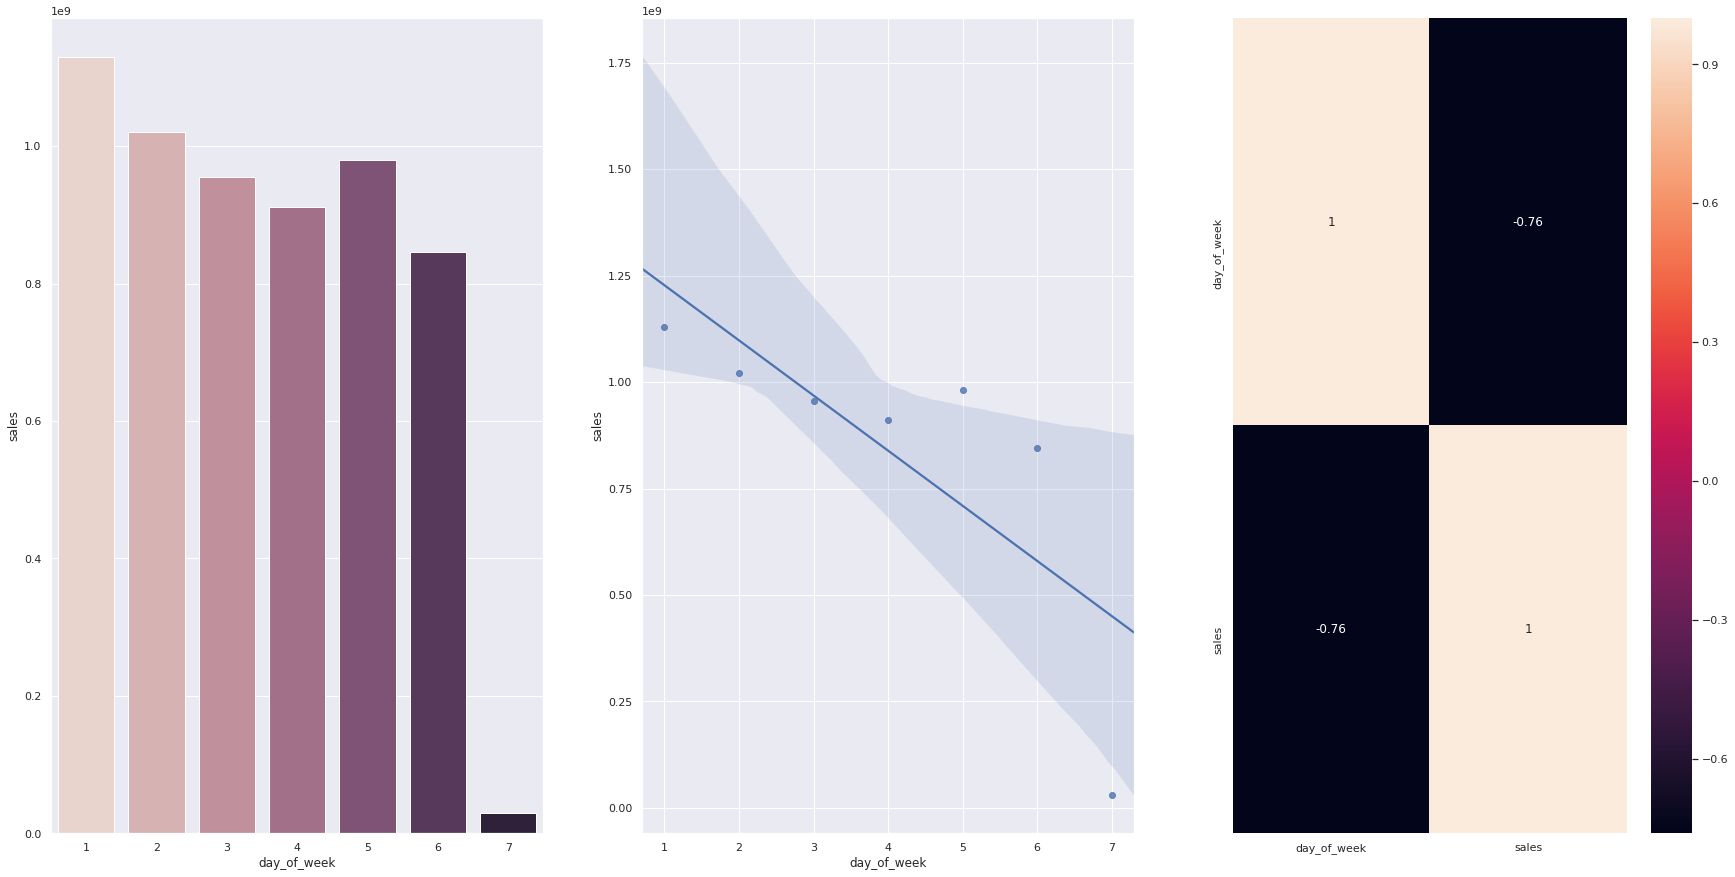

In [51]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1, palette="ch:.05");

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);


#### H12. Stores should sell less during school holidays.
Answer: **True**, stores sell less during school holidays, except in July and August.

Here we find another Insight. The dataframe was granted by Rossmanns-Europe where the holiday period starts in August and peaks in August, I believe that's why we see this shift so high in month 8

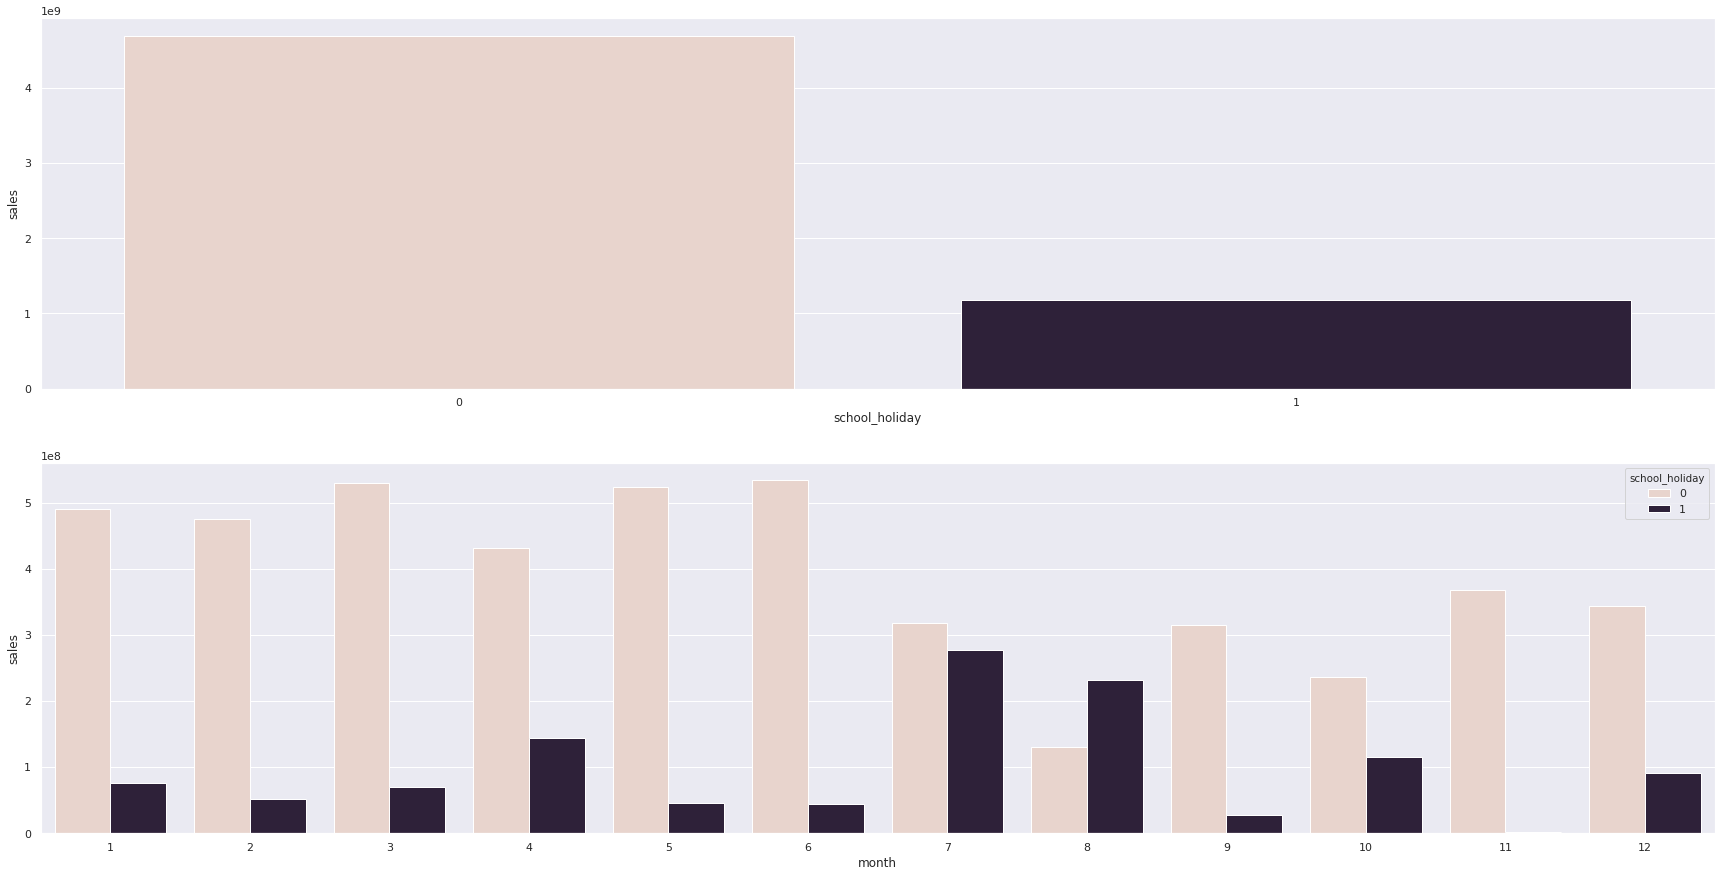

In [52]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
# o = normaç day and 1 = school holiday
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1, palette="ch:.05");

# here we saw that in the months with more school holidays (holiday months) sales in relation to this do increase (but we cannot have that in relation to this).
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, palette="ch:.05");

### 4.2.1 Hypothesis Summary

In [53]:
#Plotting the Boruta selection to compare with what was found by exploratory analysis as relevant and by boruta
#cols_selected_boruta


In [54]:
#from tabulate import tabulate

tab = [['Hyposthesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Median'],
       ['H3', 'False', 'Median'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Median'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow'))

Hyposthesis    Conclusion    Relevance
-------------  ------------  -----------
H1             False         Low
H2             False         Median
H3             False         Median
H4             False         Low
H5             -             -
H6             False         Low
H7             False         Median
H8             False         High
H9             False         High
H10            True          High
H11            True          High
H12            True          Low


### 4.3. Multivariate Analysis


#### 4.3.1. Numerical attributes
Warning: The motivation of multivariate analysis is important for the application of ML, and it is very important to understand the dimensionality of the dataframe. Because of this, it is important to always choose the least complex, because the smaller the dataframe, the easier machine learning will be and with that we will have a better result. A way to eliminate columns to reduce the dimensionality of the DF and choose columns whose values tell the same story.

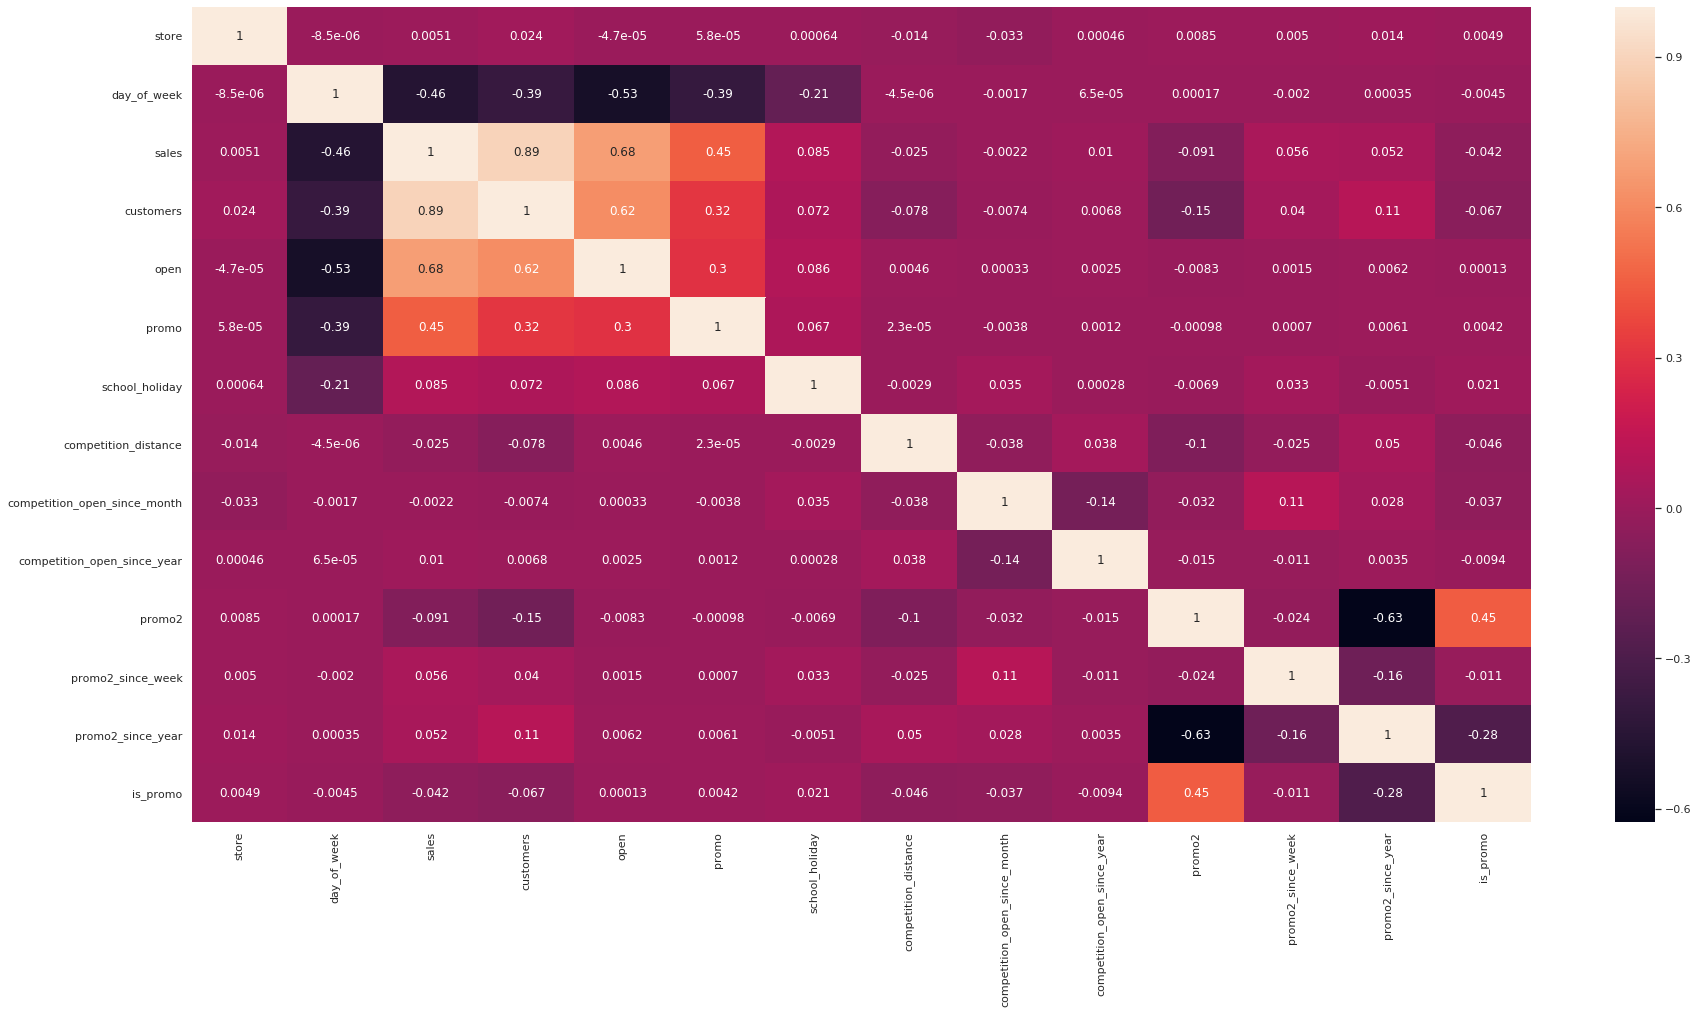

In [55]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


#### 4.3.2. Categorical attributes

<font color="red"> Person is a correlation method for numerical values.
<font color="red"> V-Krumer is used for categorical correlation.

               state_holiday  store_type  assortment
state_holiday       1.000002    0.071065    0.067546
store_type          0.071065    1.000002    0.538457
assortment          0.067546    0.538457    1.000001


'Notice that there is a "strong" correlation only between the "store_type" and the "assortment".'

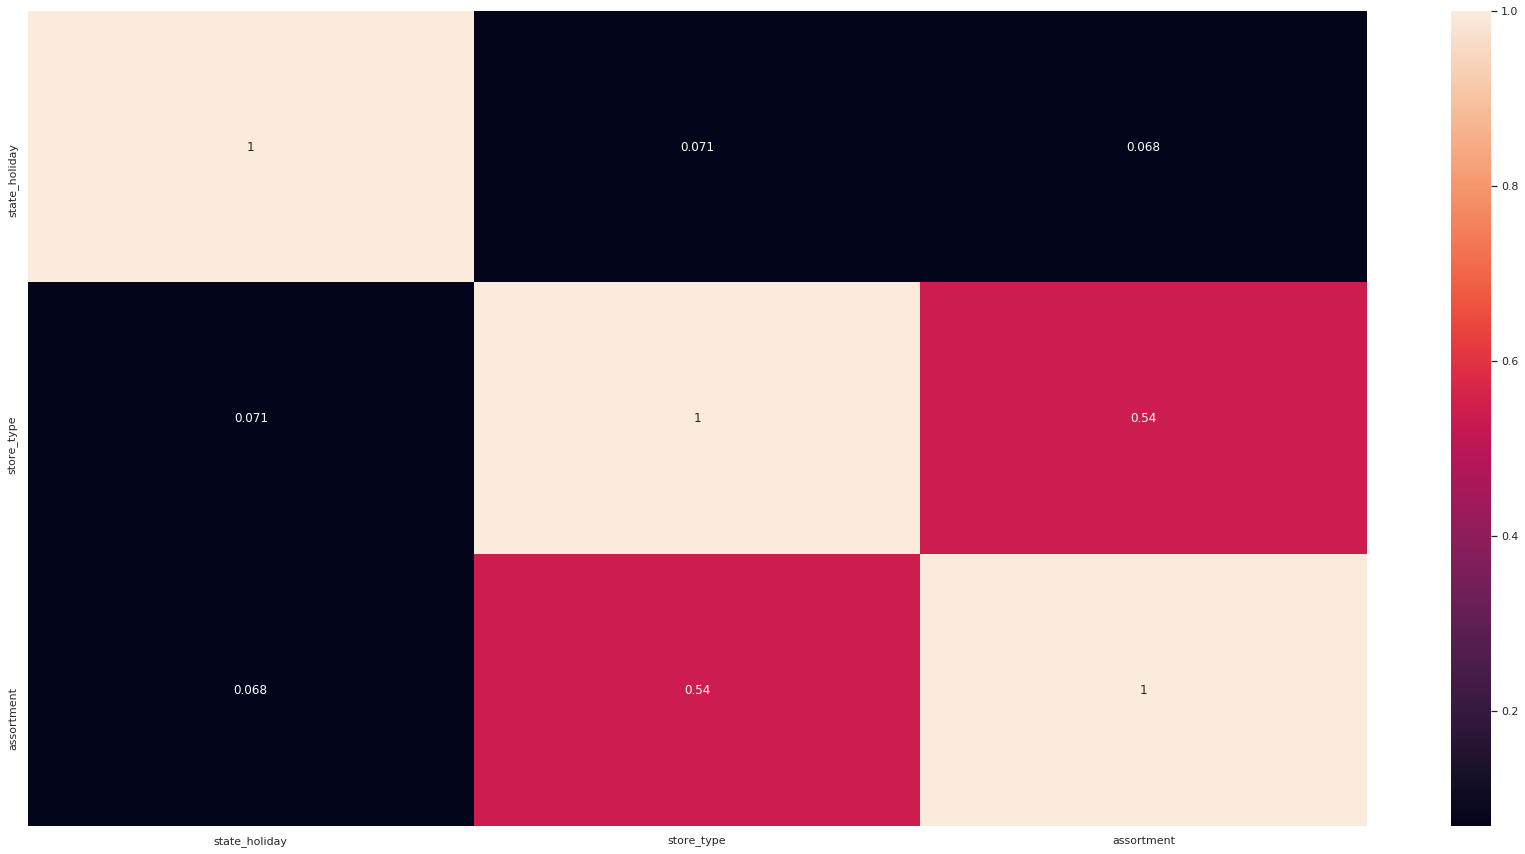

In [56]:
# Setting up the table
# 1st Only categorical data analysis method V-Krumer
a = df4.select_dtypes( include='object' )

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# 3º Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9]} )

d = d.set_index( d.columns )
print(d)


sns.heatmap( d, annot=True );
'''Notice that there is a "strong" correlation only between the "store_type" and the "assortment".'''

# 5.0. Step 05 -  DATA PREPARATION

### Read df_eda DataFrame

In [60]:
df5 = df4.copy()

In [61]:
df5['date'] = pd.to_datetime( df5['date'] )
df5['competition_open_since_month'] = df5['competition_open_since_month'].astype( int )
df5['competition_open_since_year'] = df5['competition_open_since_year'].astype( int )

df5['promo2_since_week'] = df5['promo2_since_week'].astype( int )
df5['promo2_since_year'] = df5['promo2_since_year'].astype( int )
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

### 5.1. Normalization

#### It is not necessary for us to put in this dataset

### 5.2. Rescaling

In [62]:
#from sklearn.preprocessing import RobustScaler, MinMaxScaler
a = df5.select_dtypes( include=[ 'int64', 'float64' ] )


In [63]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


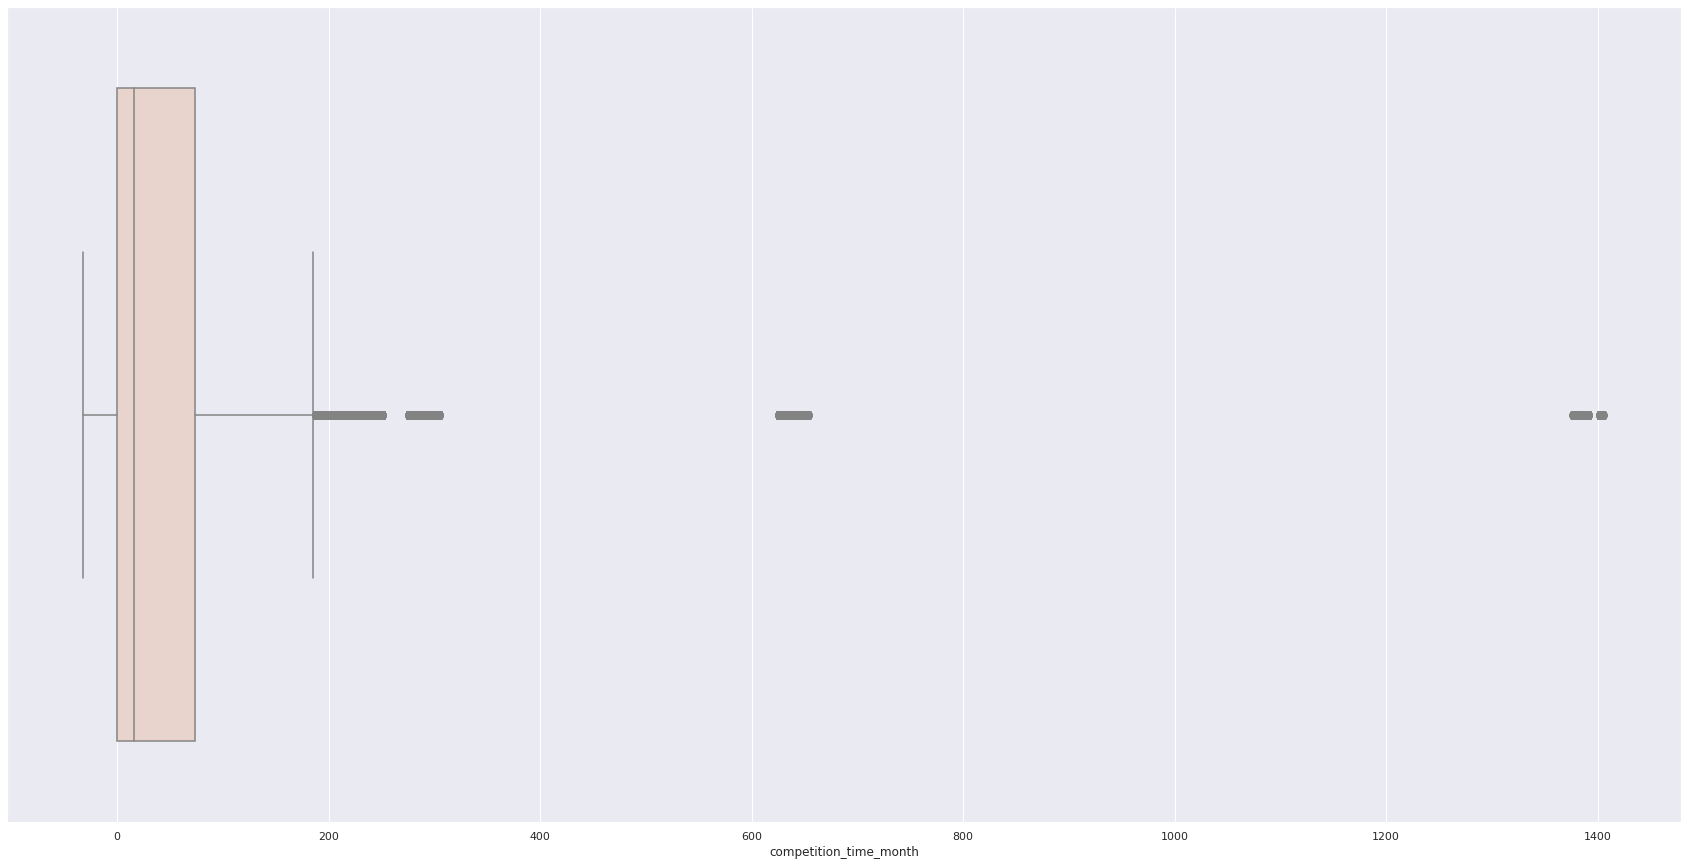

In [64]:
#sns.boxplot( df5[['competition_distance', 'competition_time_month']] )
sns.boxplot( df5['competition_time_month'], palette="ch:.05" );
# using this comand, olny looked if exist or no outlayers
# usar os interquartis ou o RobustScaling nos livra das dependencias das outlayers

In [65]:
# #from sklearn.preprocessing import RobustScaler
# # Preparing the data
# rs = RobustScaler() 
# mms = MinMaxScaler()
# 
# # competition_distance
# df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))
# 
# # competition_time_month
# df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))
# 
# # promo_time_week 
# df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))
# 
# # year
# df5['year'] = mms.fit_transform( df5[['year']].values )
# pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))
# 

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/competition_distance_scaler.pkl'

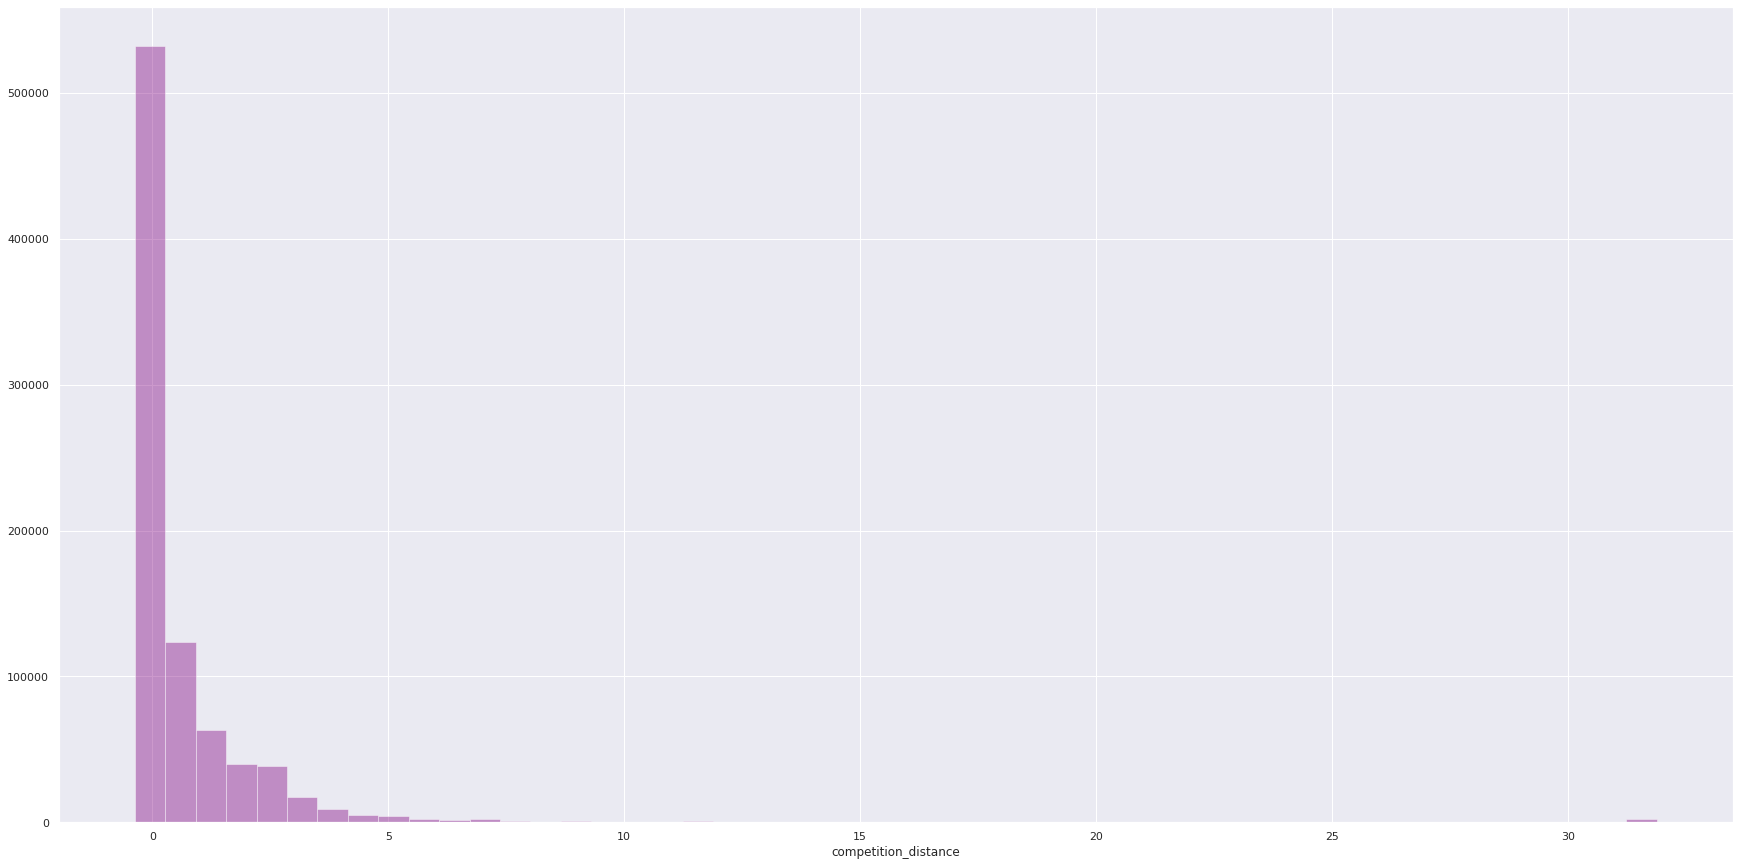

In [66]:
sns.distplot( df5['competition_distance'], kde=False, color='purple' );

### 5.3. Transformation

#### 5.3.1. Enconding
    - state_holiday - One Hot Enconding
    - store_type - Label enconding
    - assortment - Ordinal Encoding

In [69]:
df5.head(2)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


In [70]:
# state_holiday - using One Hot Enconding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [71]:
# Aplly in next cycle
#le = LabelEncoder()
#df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '../parameter/store_type_scaler.pkl'

In [72]:
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3} 
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [73]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1


#### 5.3.2. Response Variable Transformation

In [74]:
df5['sales'] = np.log1p( df5['sales'] )

In [75]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1


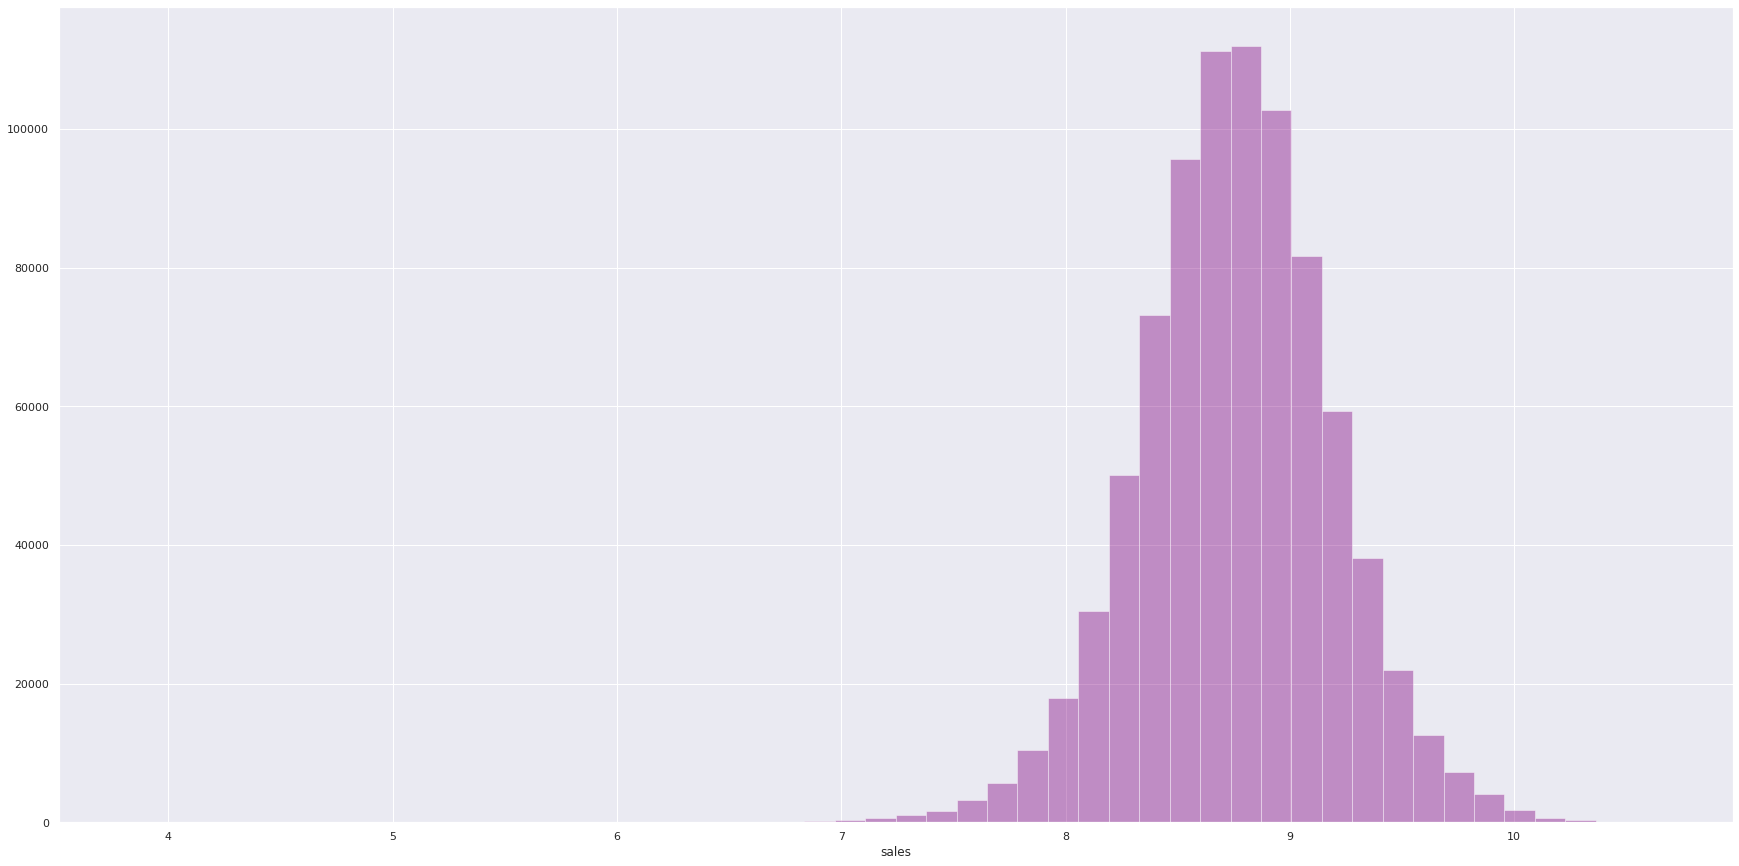

In [76]:
sns.distplot( df5['sales'], kde=False, color='purple'); 

#### 5.3.3. Nature Transformation → Ciclical Transformation

In [77]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7 ))) 
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12 ))) 
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30 ))) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30 )))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52 ))) 
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52 )))

In [78]:
# New DataFrame
df5.to_csv('../dataset/df5_preparation.csv')

# 6.0. Step 06 -  FEATURE SELECTION

In [10]:
# New Data Frame
df_transf = pd.read_csv('../dataset/df5_preparation.csv')
df_transf.head()

,Unnamed: 0,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [11]:
df6 = df_transf.copy()

In [12]:
df6['date'] = pd.to_datetime( df6['date'] )
df6['competition_open_since_month'] = df6['competition_open_since_month'].astype( int )
df6['competition_open_since_year'] = df6['competition_open_since_year'].astype( int )

df6['promo2_since_week'] = df6['promo2_since_week'].astype( int )
df6['promo2_since_year'] = df6['promo2_since_year'].astype( int )
df6.dtypes

Unnamed: 0                               int64
store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

### 6.1. Slpit DataFrame into training dataset

In [13]:
# Occan's Razor Principle → Eliminating Collinear Variables
# whenever we have variables that have equal or collinear values we can eliminate
# and thus have a leaner dataset optimizing our learning model.
cols_drop = ['Unnamed: 0', 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [14]:
#grouping by date to analyze when sales started for the training set
#df6[['store', 'date']].groupby('store').min().reset_index()

# grouping by date to analyze when was the last sale for the training set
#df6[['store', 'date']].groupby('store').max().reset_index()

#subtracting 6 weeks to know the first date of the last 6 weeks
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [15]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

In [16]:
# testing dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

In [17]:
# Plot train and testing 
print( 'Training Min Date: {}'.format( X_train['date'].min() ))
print( 'Training Max Date: {}'.format( X_train['date'].max() ))
print( '\nTesting Min Date: {}'.format( X_test['date'].min() ))
print( 'Testing Max Date: {}'.format( X_test['date'].max() ))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


### 6.2. Boruta as Feature Selector
Don't run again!

In [84]:
#from boruta import BorutaPy
#from sklearn.ensemble import RandomForestRegressor

In [85]:
#from boruta import BorutaPy
#from sklearn.ensemble import RandomForestRegressor

In [86]:
#BorutaPy( rf, n_estimators=10, verbose=2, random_state=42 ) # → definição do Boruta


#### define training and test for Boruta (generating features with boruta)
# X_train_n = X_train.drop(['date','sales'], axis=1 ).values #define the variable and eliminate unwanted variables for this workout 
# y_train_n = y_train.values.ravel() #Using ravel to put all this into a vector 

#define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=3 ) #define the use of all colors of the machine and do it in parallel and work faster 

# → Running the training with the method  .fit() = it is necessary to inform a vector of numbers (numpy → x_train_n..)
# boruta = BorutaPy( rf, n_estimators=10, verbose=2, random_state=42 ).fit(X_train_n, y_train_n ) 


#### 6.2.1. Best Features from Boruta


In [87]:
# Displays the rank of variables based on a range of values showing which are the best and which are the least interesting for our answer
# cols_selected = boruta.support_.tolist() # → creating a list of the best columns in the set

# Best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1 ) #→ necessary to create a new feature to select within cols_boruta the columns found by the model
# cols_selected_boruta = X_train_fs.iloc[: , cols_selected].columns.to_list() #→ boruta returns a dataframe so it transforms into list

# Comparing selected and unselected columns
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [88]:
# Call Boruta result.
#boruta
# cols_selected_boruta

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=None,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=73, n_jobs=-1,
                                         oob_score=False,
                                         random_state=RandomState(MT19937) at 0x7F2D0B3B0E20,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=RandomState(MT19937) at 0x7F2D0B3B0E20, two_step=True,
         verbose=2)

### 6.3. Manual Feature Selection

In [89]:
# cols_selected_boruta #→ return collumns boruta selected

In [18]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [19]:
# columns to add - adding manually dropped variables to the end of the list.
feat_to_add = ['date', 'sales']

# week_of_year_sin and month_sin were manually assigned because they had relevance in our EDA
# during the validation of hypotheses. comparing to ussa tabela e a tabela do boruta realizamos o merge
# and we force learning with our manual analysis

In [20]:
# final features (features droped + cols_selected_boruta + EDA)
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# command to add manual list to end of first list

# 7.0. Step 07 - MACHINE LEARNING MODELLING → test and choose the best model for our analysis

In [24]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [25]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error


In [26]:
# generating the mean_absolute_error function because we haven't implemented it in numpy yet
def mean_absolute_percentage_error(y, yhat): # receives actual value for predicted
    return np.mean( np.abs(( y - yhat ) / y )) # abs function turns negative to positive

# Function implementation ML_ERROR
def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

## 7.1. Average Model → in the comparison between the models, this one behaved better

In [18]:
# avg model → average sales per store
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() 

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'}) 
aux1 = pd.merge( aux1, aux2, how='left', on='store') 
yhat_baseline = aux1['predictions'] 

# Performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline )) 
baseline_result 

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [102]:
#from sklearn.linear_model import LinearRegression, Lasso

In [19]:
# model
lr = LinearRegression().fit( x_train, y_train ) 

# prediction
yhat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

 - The real value

In [20]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularied Model - Lasso

In [21]:
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance 
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1889.425058,0.294563,2720.392711


### 7.3.1 Linear Regression Regularied Model - Lasso

In [22]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.57 +/- 343.78,0.29 +/- 0.01,3048.94 +/- 509.59


## 7.4. Random Forest Regressor

In [24]:
#from sklearn.ensemble import RandomForestRegressor

In [23]:
# model
rf = RandomForestRegressor( n_estimators=60, n_jobs=3, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.022205,0.100616,1016.939986


### 7.4.1.  Random Forest Regressor - Cross Validation


In [24]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv
# Model Name	MAE CV	MAPE CV	RMSE CV
# 0	Random Forest Regressor	839.53 +/- 216.46	0.12 +/- 0.02	1259.02 +/- 316.7


KFold number: 5

KFold number: 4

KFold number: 3

KFold number: 2

KFold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.53 +/- 216.46,0.12 +/- 0.02,1259.02 +/- 316.7


## 7.5. XGBoost Regressor

In [83]:
#import xgboost as xgb

In [25]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,851.278592,0.123671,1265.695962


In [26]:
with open('../model/xgb_result.pkl', 'wb') as f:
    pickle.dump(xgb_result, f)

In [27]:
xgb_result = pickle.load(open ('../model/xgb_result.pkl', 'rb'))  

In [28]:
xgb_result
#"""Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	6635.050477	0.941713	7283.881093 → 10 tree"""

#'''Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	2434.527038	0.302996	3245.532275 → 30 tree'''

#'''Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	1011.47553	0.146031	1497.513356 → 70 tree'''

#'''Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	851.278592	0.123671	1265.695962 → 100 tree'''

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,851.278592,0.123671,1265.695962


### 7.5.1. XGBoost Regressor - Cross Validation

In [29]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold number: 5

KFold number: 4

KFold number: 3

KFold number: 2

KFold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1017.94 +/- 170.79,0.14 +/- 0.02,1463.65 +/- 234.28


In [18]:
# Model Name	MAE CV	MAPE CV	RMSE CV
# 0	XGBoost Regressor	1017.94 +/- 170.79	0.14 +/- 0.02	1463.65 +/- 234.28

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [51]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )

modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.022205,0.100616,1016.939986
0,XGBoost Regressor,851.278592,0.123671,1265.695962
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression - Lasso,1889.425058,0.294563,2720.392711
0,Linear Regressor,1980.039151,0.283893,2840.000319


In [52]:
"""Completion of this analysis:
The problem we are trying to analyze (Rossmann) is not a simple problem, and for being
so complex we must apply deeper learning models, shown in the results
of the comparison."""

'Completion of this analysis:\nThe problem we are trying to analyze (Rossmann) is not a simple problem, and for being\nso complex we must apply deeper learning models, shown in the results\nof the comparison.'

### 7.6.2. Real Performance - Cross Validation

In [53]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2113.57 +/- 343.78,0.29 +/- 0.01,3048.94 +/- 509.59
0,Random Forest Regressor,839.53 +/- 216.46,0.12 +/- 0.02,1259.02 +/- 316.7
0,XGBoost Regressor,1017.94 +/- 170.79,0.14 +/- 0.02,1463.65 +/- 234.28


#### Save the Model of machine Learning

In [62]:
with open('../model/sale_xgboost.pkl', 'wb') as f:
    pickle.dump(modelling_result_cv, f)
    
    

In [63]:
arq = open('../model/sale_xgboost.pkl', 'rb') 
   
x = pickle.load(arq)

In [64]:
x

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2113.57 +/- 343.78,0.29 +/- 0.01,3048.94 +/- 509.59
0,Random Forest Regressor,839.53 +/- 216.46,0.12 +/- 0.02,1259.02 +/- 316.7
0,XGBoost Regressor,1017.94 +/- 170.79,0.14 +/- 0.02,1463.65 +/- 234.28


# 8.0. Step 08 - Hipyer Parameter Fine Tuning

In [4]:
import random
import warnings

warnings.filterwarnings( 'ignore' )

## 8.1. Random Search
    

In [21]:
param = {'n_estimators': [100, 350, 500, 800, 950], 
         'eta': [0.01, 0.03], 
         'max_depth': [3, 5, 9], 
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15] }

MAX_EVAL = 5 

### Run only in case of feature changes

In [27]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL):
    # Choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp) 
    
    # model XgBoost
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytee'],
                                  min_child_weight=hp['min_child_weight'] ) 

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False ) 
        
    final_result = pd.concat([final_result, result])

final_result   

{'n_estimators': 950, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'n_estimators': 800, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 950, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 3}
{'n_estimators': 350, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1242.35 +/- 129.62,0.17 +/- 0.01,1780.52 +/- 163.42
0,XGBoost Regressor,967.59 +/- 144.25,0.14 +/- 0.02,1377.06 +/- 194.23
0,XGBoost Regressor,874.79 +/- 127.54,0.12 +/- 0.01,1247.21 +/- 180.74
0,XGBoost Regressor,1454.64 +/- 156.6,0.2 +/- 0.01,2092.43 +/- 190.82
0,XGBoost Regressor,876.82 +/- 139.17,0.12 +/- 0.01,1251.63 +/- 193.45


In [48]:
#final_result
# Here, choose the one with the best result on the RMSE CV (lowest result)
#or the one whose parameters are smaller but the errors are very close

"""
1 - {'n_estimators': 800, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}
2   {'n_estimators': 950, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 15}
3   {'n_estimators': 500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 8}
4   {'n_estimators': 800, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 8} → escolhi este pela proximidade de valores ao melhor estimador
5 - {'n_estimators': 950, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 8}"""


'''{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 800, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 800, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}  → escolhido pelo modelo
{'n_estimators': 100, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 8}
{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 15}
Model Name	MAE CV	MAPE CV	RMSE CV
0	XGBoost Regressor	1527.56 +/- 109.89	0.21 +/- 0.0	2227.36 +/- 177.93
0	XGBoost Regressor	1231.43 +/- 97.16	0.17 +/- 0.0	1789.61 +/- 151.99
0	XGBoost Regressor	776.66 +/- 121.34	0.11 +/- 0.01	1126.29 +/- 187.18
0	XGBoost Regressor	1785.22 +/- 123.03	0.25 +/- 0.0	2579.52 +/- 189.79
0	XGBoost Regressor	1542.55 +/- 103.1	0.22 +/- 0.0	2245.35 +/- 158.46'''

"""Teste dia 23/12
{'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'n_estimators': 950, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}
→ {'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 3}

|Model Name	|MAE CV	|MAPE CV	|RMSE CV|
|======*|======*|======*|======*|
1	XGBoost Regressor	1397.64 +/- 110.28	0.2 +/- 0.0	2040.59 +/- 164.63
2	XGBoost Regressor	1398.91 +/- 109.5	0.2 +/- 0.0	2043.59 +/- 162.17
3	XGBoost Regressor	862.99 +/- 99.94	0.12 +/- 0.01	1235.09 +/- 148.75
4	XGBoost Regressor	814.49 +/- 119.37	0.11 +/- 0.01	1171.58 +/- 179.18
5	XGBoost Regressor	1539.8 +/- 108.17	0.22 +/- 0.0	2248.29 +/- 167.92"""

"Teste dia 23/12\n{'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}\n{'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}\n{'n_estimators': 950, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}\n→ {'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}\n{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 3}\n\n|Model Name\t|MAE CV\t|MAPE CV\t|RMSE CV|\n|======*|======*|======*|======*|\n1\tXGBoost Regressor\t1397.64 +/- 110.28\t0.2 +/- 0.0\t2040.59 +/- 164.63\n2\tXGBoost Regressor\t1398.91 +/- 109.5\t0.2 +/- 0.0\t2043.59 +/- 162.17\n3\tXGBoost Regressor\t862.99 +/- 99.94\t0.12 +/- 0.01\t1235.09 +/- 148.75\n4\tXGBoost Regressor\t814.49 +/- 119.37\t0.11 +/- 0.01\t1171.58 +/- 179.18\n5\tXGBoost Reg

## 8.2. Final Model
    

In [28]:
param_tuned = {'n_estimators': 350, 
               'eta': 0.01, 
               'max_depth': 9, 
               'subsample': 0.1, 
               'colsample_bytee': 0.9, 
               'min_child_weight': 3}

MAX_EVAL = 3 

In [29]:
# model XgBoost
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, y_train) 

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) ) 
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,688.833353,0.101738,994.372393


In [30]:
#model_xgb_tuned_final = pickle.load(open ('/home/bruno/repos/Rossmann_Sales_Prediction_bmg/model/model_rossmann.pkl', 'rb'))

# save the final model
with open('../model/model_rossmann.pkl', 'wb') as file:
    pickle.dump(xgb_result_tuned, file)

In [31]:
model_xgb_tuned_final = pickle.load(open ('/home/bruno/repos/Rossmann_Sales_Prediction_bmg/model/model_rossmann.pkl', 'rb'))
#model_xgb_tuned_final

In [32]:

yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

## performance
xgb_result_tuned_final = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) ) 
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,688.833353,0.101738,994.372393


### Calculating the MEP

mpe = mean_percentage_error( np.expm1( y_test), np.expm1(yhat_xgb_tuned) )
mpe

# 9.0. Step 09 - Error Translation and Interpretation


In [33]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [34]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum(). reset_index()

# MAE and MAPE → report error translate
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store') 
df92 = pd.merge(df91, df9_aux3, how='inner', on='store') 


In [35]:
# The best and worst scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [36]:
df92.head(3)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162411.859375,162117.454887,162706.263863,294.404488,0.065719
1,2,177249.046875,176871.994998,177626.098752,377.051877,0.079791
2,3,261931.453125,261354.514807,262508.391443,576.938318,0.080235


In [37]:
df92.head(4)


# store	predictions	worst_scenario	best_scenario	MAE	MAPE
# 0	1	165412.546875	165107.490591	165717.603159	305.056284	0.070525
# 1	2	177184.250000	176791.037037	177577.462963	393.212963	0.081222
# 2	3	261015.484375	260466.587066	261564.381684	548.897309	0.075778
# 3	4	342521.281250	341593.853238	343448.709262	927.428012	0.088899


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162411.859375,162117.454887,162706.263863,294.404488,0.065719
1,2,177249.046875,176871.994998,177626.098752,377.051877,0.079791
2,3,261931.453125,261354.514807,262508.391443,576.938318,0.080235
3,4,345611.468750,344727.237344,346495.700156,884.231406,0.084374


In [38]:
# How to show the business team which stores are more challenging in the prediction?

df92.sort_values('MAPE', ascending=False ).head()

# store	predictions	worst_scenario	best_scenario	MAE	MAPE
# 291	292	106656.007812	103351.642488	109960.373137	3304.365324	0.558269
# 908	909	240363.890625	232507.283819	248220.497431	7856.606806	0.539573
# 594	595	347225.218750	342306.630160	352143.807340	4918.588590	0.340322
# 875	876	205642.437500	201502.395879	209782.479121	4140.041621	0.326377
# 721	722	352791.593750	350805.226193	354777.961307	1986.367557	0.267940

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107721.984375,104267.235531,111176.733219,3454.748844,0.607736
908,909,228006.625000,220072.920814,235940.329186,7933.704186,0.527464
285,286,169510.140625,168609.332447,170410.948803,900.808178,0.322231
594,595,358482.000000,353867.648860,363096.351140,4614.351140,0.315539
875,876,192926.015625,188991.725437,196860.305813,3934.290188,0.290832


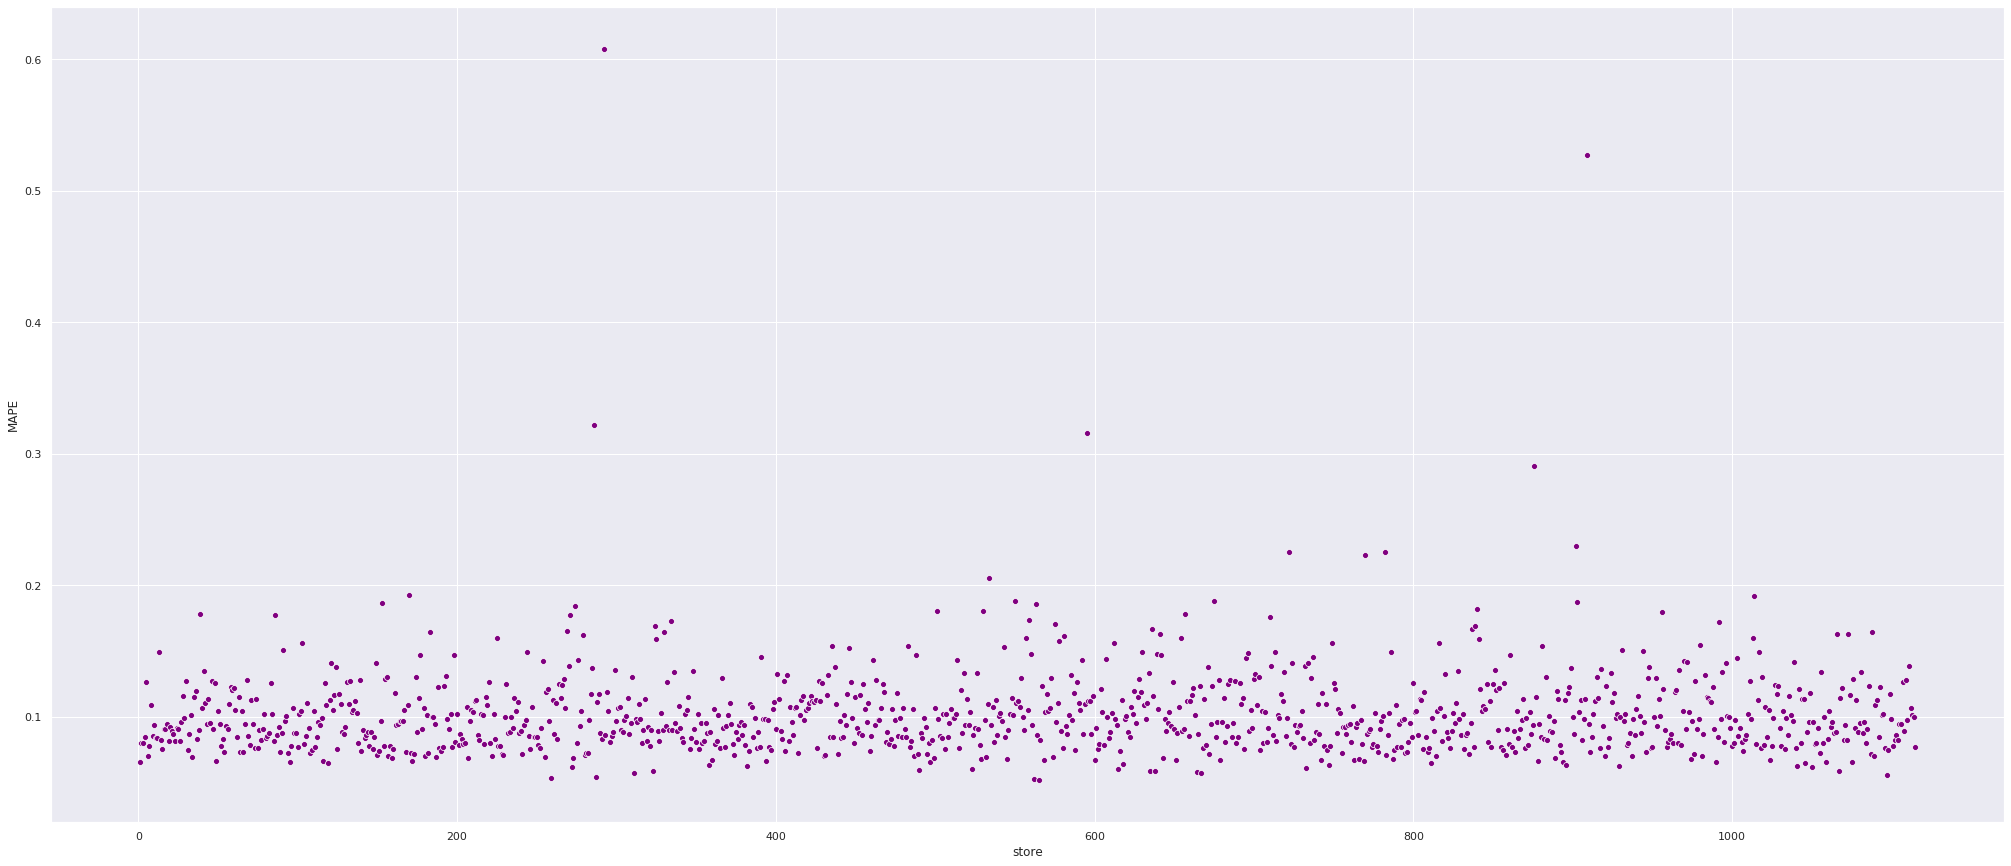

In [39]:
sns.scatterplot(x='store', y='MAPE', data=df92, color="purple" );

## 9.2 Total Performance

In [40]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('€{:,.2f}'.format)
df93

# Scenario	Values
# 0	predictions	€286,066,344.23
# 1	worst_scenario	€285,305,077.05
# 2	best_scenario	€286,827,611.42

,Scenario,Values
0,predictions,"€286,381,809.29"
1,worst_scenario,"€285,609,778.34"
2,best_scenario,"€287,153,840.24"


## 9.3 Machine Learning Performance

In [41]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


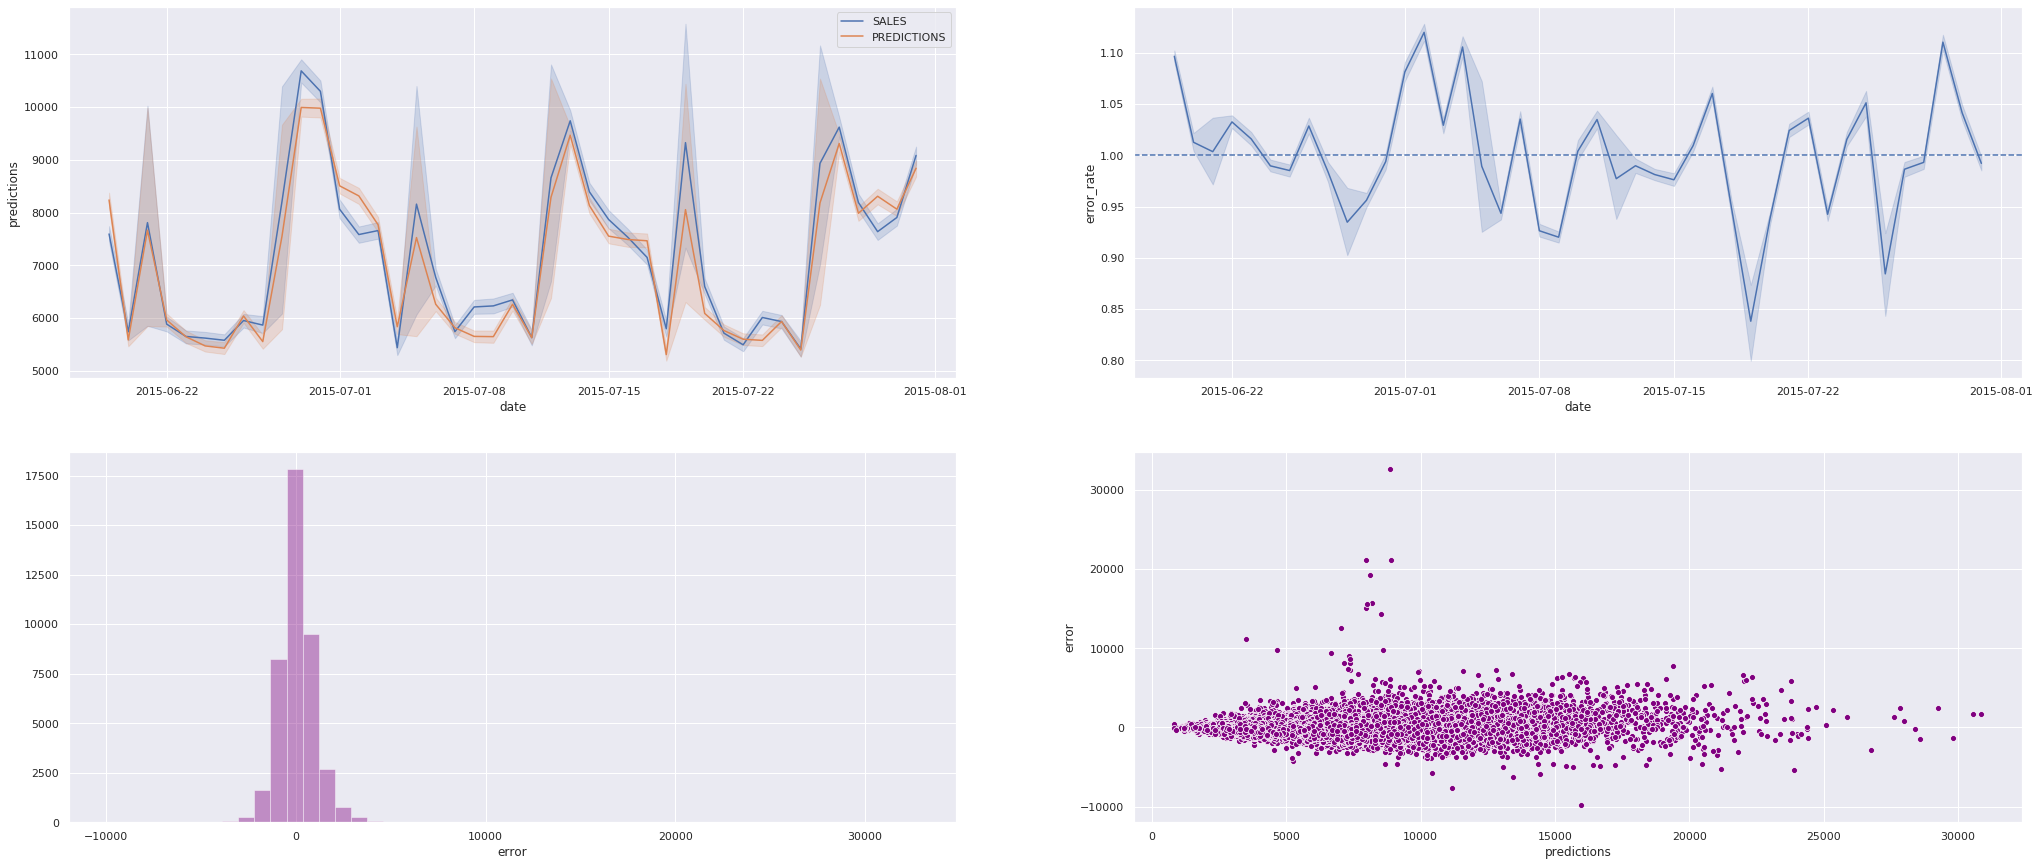

In [42]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');


plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--'); 

plt.subplot(2, 2, 3)
sns.distplot(df9['error'], kde=False, color='purple');

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'], color='purple');

# 10.0. Step 10 - Deploy Model to Production


## 10.1 Rossmann Class

In [84]:
import math
import pickle
import datetime
import inflection

import numpy  as np
import pandas as pd


class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/bruno/repos/Rossmann_Sales_Prediction_bmg/' 
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'webapp/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'webapp/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'webapp/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'webapp/parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'webapp/parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        # Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list(map(snakecase, cols_old))
        
        #rename
        df1.columns = cols_new


        # Data Types

        df1['date'] = pd.to_datetime( df1['date'])


        # Fillout "NA" 

        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

        #promo2_since_week  
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

        #promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True)
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

        # Change Data Types
        
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1

    def feature_engineering(self, df2):
        
        #Feature Engineering

        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear 

        #year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

        #competition since 
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                           month=x['competition_open_since_month'],
                                                                           day=1), axis=1 )
        
        #competition time month
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype( int )

        #promo since 
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x:datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
        
        #promo time week
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # FILTERING VARIABLE
        
        # Filtering Rows
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        # Filtering columns
        cols_drop = ['customers', 'open',  'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop,axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
        # Rescaling
        
        #competition_tdistance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo_time_week 
        df5['promo_time_week'] = self.promo_time_week_sclaer.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
    

        # Transformation
        #Enconding
        
        #state_holiday - using One Hot Enconding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        #store_type - Label enconding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
         
        #assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3} 
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # Nature Transformation → Ciclical Transformation

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * pi/7 )))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * pi/7 )))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * pi/12 )))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * pi/12 )))
        
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * pi/30 )))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * pi/30 )))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * pi/52 )))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * pi/52 )))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]

    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')


## 10.2. API Handler

In [85]:
import os
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open('/home/bruno/repos/Rossmann_Sales_Prediction_bmg/model/model_rossmann.pkl', 'rb') )

# Initializing API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there are data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning( test_raw )
                
        # Feture engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # Data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        
        return Response( '{}', status=200, mimetype='application/json') #reader to request

if __name__ == '__main__':
    app.run('0.0.0.0') # local host 

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [86]:
import json
import requests
import pandas as pd

df_store_raw = pd.read_csv('../dataset/store.csv', low_memory=False)
df10 = pd.read_csv( '../dataset/test.csv' )

In [87]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([22, 24, 30])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [81]:
# Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records') )

In [82]:
data

'[{"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 24, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 4590.0, "CompetitionOpenSinceMonth": 3.0, "CompetitionOpenSinceYear": 2000.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2011.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 30, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 40.0, "CompetitionOpenSinceMonth": 2.0, "CompetitionOpenSinceYear": 2014.0, "Promo2": 1, "Promo2SinceWeek":

In [88]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://bg-rossmann-predict.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

#r = requests.post( url=url, data=data )



r = requests.post( url, data=data, headers=header) #→ original code
print( 'Status Code {}'.format( r.status_code ) )
#r = requests.post( url, data=json.dumps(data)) 
#r = requests.post( url, data=json.dumps(data), allow_redirects=False) 
# (https://docs.python-requests.org/pt_BR/latest/user/quickstart.html#conteudo-da-resposta)




Status Code 500


In [12]:
r.json()

JSONDecodeError: [Errno Expecting value] <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
: 0

In [7]:
# return to dataframe
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print('Store Number {} will sell €{:,.2f} in the next six weeks'. format(
           d2.loc[i, 'store'],
           d2.loc[i, 'prediction'] ) )

KeyError: 0